# 1. Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import plotly.express as px

import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer


# 2. Load Dataset

In [ ]:
# Menghubungkan Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path file CSV di Google Drive
file_path = '/content/drive/My Drive/JAP Rakamin/Predict Customer Personality to Boost Marketing Campaign by Using Machine Learning/marketing_campaign_data.csv'

# Membaca file CSV menggunakan pandas
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Dataset Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           2240 non-null   int64  
 1   ID                   2240 non-null   int64  
 2   Year_Birth           2240 non-null   int64  
 3   Education            2240 non-null   object 
 4   Marital_Status       2240 non-null   object 
 5   Income               2216 non-null   float64
 6   Kidhome              2240 non-null   int64  
 7   Teenhome             2240 non-null   int64  
 8   Dt_Customer          2240 non-null   object 
 9   Recency              2240 non-null   int64  
 10  MntCoke              2240 non-null   int64  
 11  MntFruits            2240 non-null   int64  
 12  MntMeatProducts      2240 non-null   int64  
 13  MntFishProducts      2240 non-null   int64  
 14  MntSweetProducts     2240 non-null   int64  
 15  MntGoldProds         2240 non-null   i

Key Takeaways:

- Dataset terdapat 2.240 baris dan 30 kolom
- Dataset terdiri dari 26 kolom bertipe **int64**, 1 kolom bertipe **float64**, dan 3 kolom bertipe **object**
- Terdapa null value pada kolom **Income**

# 4. Feature Engineering

### Conversion Rate

In [ ]:
df['NumWebVisitsMonth'] = df['NumWebVisitsMonth'].replace(0, 0.01)
df['Conversion_Rate'] = df['Response'] / df['NumWebVisitsMonth']
df['Conversion_Rate'].value_counts()

Conversion_Rate
0.000000    1906
0.125000      57
0.166667      48
0.142857      45
0.500000      40
0.333333      33
1.000000      30
0.111111      29
0.250000      26
0.200000      25
0.100000       1
Name: count, dtype: int64

### Customer Age

In [ ]:
# Menghitung Umur
current_year = 2024
df['Age'] = current_year - df['Year_Birth']
df['Age'].value_counts()

Age
48     89
53     87
49     83
52     79
46     77
54     77
51     74
59     74
55     71
50     69
68     55
66     53
45     53
72     52
47     52
56     51
65     51
58     50
70     50
69     49
64     49
42     45
61     45
57     44
62     44
67     43
73     43
41     42
38     42
60     42
44     39
43     39
40     38
63     36
71     35
39     32
35     30
75     30
74     29
36     29
37     27
76     21
34     18
78     16
77     16
33     15
32     13
79      8
81      7
80      7
31      5
29      5
30      3
28      2
125     1
83      1
131     1
124     1
84      1
Name: count, dtype: int64

In [ ]:
# Kategori Umur
def age_category(age):
    if age < 35:
        return 'Millennial'
    elif age < 55:
        return 'Gen X'
    else:
        return 'Baby Boomer'

df['Age_Category'] = df['Age'].apply(age_category)
df['Age_Category'].value_counts()

Age_Category
Gen X          1103
Baby Boomer    1076
Millennial       61
Name: count, dtype: int64

### Total Child

In [ ]:
# Menghitung Total Anak
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Children'].value_counts()

Total_Children
1    1128
0     638
2     421
3      53
Name: count, dtype: int64

### Total Transaction

In [ ]:
purchase_columns = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['Total_Transactions'] = df[purchase_columns].sum(axis=1)
df['Total_Transactions'].value_counts()

Total_Transactions
7     149
5     145
4     128
6     123
17    116
9     102
19    101
16    101
21     95
8      94
22     94
20     94
23     87
10     80
18     79
15     74
12     70
25     68
26     67
11     67
24     56
14     55
13     44
27     39
28     35
29     19
32     12
30     11
31     11
1       4
0       4
33      4
34      4
2       3
37      1
39      1
35      1
43      1
44      1
Name: count, dtype: int64

### Total Accepted Campaign

In [ ]:
# Menghitung total accepted campaign
df['Total_Accepted_Campaigns'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['Total_Accepted_Campaigns'].value_counts()


Total_Accepted_Campaigns
0    1777
1     325
2      83
3      44
4      11
Name: count, dtype: int64

### Total Spending

In [ ]:
# Menentukan kolom yang berisi pengeluaran untuk produk-produk yang berbeda
spending_columns = ['MntFishProducts', 'MntMeatProducts', 'MntFruits', 'MntSweetProducts', 'MntCoke', 'MntGoldProds']
df['Total_Spending'] = df[spending_columns].sum(axis=1)
df['Total_Spending'].value_counts()

Total_Spending
46000      19
22000      18
57000      16
44000      15
55000      15
           ..
1345000     1
764000      1
368000      1
292000      1
843000      1
Name: count, Length: 1054, dtype: int64

# 5. Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                2240 non-null   int64  
 1   ID                        2240 non-null   int64  
 2   Year_Birth                2240 non-null   int64  
 3   Education                 2240 non-null   object 
 4   Marital_Status            2240 non-null   object 
 5   Income                    2216 non-null   float64
 6   Kidhome                   2240 non-null   int64  
 7   Teenhome                  2240 non-null   int64  
 8   Dt_Customer               2240 non-null   object 
 9   Recency                   2240 non-null   int64  
 10  MntCoke                   2240 non-null   int64  
 11  MntFruits                 2240 non-null   int64  
 12  MntMeatProducts           2240 non-null   int64  
 13  MntFishProducts           2240 non-null   int64  
 14  MntSweet

In [ ]:
# Pengelompokkan Feature
num = df.select_dtypes(include=['float64', 'int64']).columns
cat = df.select_dtypes(include=['object']).columns

## a. Statistical Summary

### Feature Numerical

In [ ]:
# Melihat jumlah value pada feature numerical
for column in df[num].columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Value counts for column 'Unnamed: 0':
Unnamed: 0
0       1
1496    1
1490    1
1491    1
1492    1
       ..
740     1
739     1
738     1
737     1
2239    1
Name: count, Length: 2240, dtype: int64


Value counts for column 'ID':
ID
5524    1
6885    1
3478    1
7494    1
1763    1
       ..
5682    1
5564    1
6516    1
6255    1
9405    1
Name: count, Length: 2240, dtype: int64


Value counts for column 'Year_Birth':
Year_Birth
1976    89
1971    87
1975    83
1972    79
1978    77
1970    77
1973    74
1965    74
1969    71
1974    69
1956    55
1958    53
1979    53
1952    52
1977    52
1968    51
1959    51
1966    50
1954    50
1955    49
1960    49
1982    45
1963    45
1967    44
1962    44
1957    43
1951    43
1983    42
1986    42
1964    42
1980    39
1981    39
1984    38
1961    36
1953    35
1985    32
1989    30
1949    30
1950    29
1988    29
1987    27
1948    21
1990    18
1946    16
1947    16
1991    15
1992    13
1945     8
1943     7
1944     7
1993     5
1995

In [ ]:
# Deskripsi Feature Numerical
df[num].describe()

,Unnamed: 0,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntCoke,MntFruits,MntMeatProducts,...,Complain,Z_CostContact,Z_Revenue,Response,Conversion_Rate,Age,Total_Children,Total_Transactions,Total_Accepted_Campaigns,Total_Spending
count,2240.000000,2240.000000,2240.000000,2.216000e+03,2240.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2.240000e+03,...,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2.240000e+03
mean,1119.500000,5592.159821,1968.805804,5.224725e+07,0.444196,0.506250,49.109375,3.039357e+05,26302.232143,1.669500e+05,...,0.009375,3.0,11.0,0.149107,0.043471,55.194196,0.950446,14.862054,0.297768,6.057982e+05
std,646.776623,3246.662198,11.984069,2.517308e+07,0.538398,0.544538,28.962453,3.365974e+05,39773.433765,2.257154e+05,...,0.096391,0.0,0.0,0.356274,0.142662,11.984069,0.751803,7.677173,0.678381,6.022493e+05
min,0.000000,0.000000,1893.000000,1.730000e+06,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,...,0.000000,3.0,11.0,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,5.000000e+03
25%,559.750000,2828.250000,1959.000000,3.530300e+07,0.000000,0.000000,24.000000,2.375000e+04,1000.000000,1.600000e+04,...,0.000000,3.0,11.0,0.000000,0.000000,47.000000,0.000000,8.000000,0.000000,6.875000e+04
50%,1119.500000,5458.500000,1970.000000,5.138150e+07,0.000000,0.000000,49.000000,1.735000e+05,8000.000000,6.700000e+04,...,0.000000,3.0,11.0,0.000000,0.000000,54.000000,1.000000,15.000000,0.000000,3.960000e+05
75%,1679.250000,8427.750000,1977.000000,6.852200e+07,1.000000,1.000000,74.000000,5.042500e+05,33000.000000,2.320000e+05,...,0.000000,3.0,11.0,0.000000,0.000000,65.000000,1.000000,21.000000,0.000000,1.045500e+06
max,2239.000000,11191.000000,1996.000000,6.666660e+08,2.000000,2.000000,99.000000,1.493000e+06,199000.000000,1.725000e+06,...,1.000000,3.0,11.0,1.000000,1.000000,131.000000,3.000000,44.000000,4.000000,2.525000e+06


Key Takeaways:
- Feature **Income**
Terdapat variasi yang signifikan dalam pendapatan, dengan nilai maksimum sekitar 666,666 yang jauh melebihi rata-rata 52,247, menunjukkan adanya kemungkinan pelanggan dengan pendapatan sangat tinggi.

- Feature **Year_Birth**
memiliki rentang tahun kelahiran dari 1893 hingga 1996, menunjukkan keberagaman umur pelanggan. Pelanggan termuda berusia 28 tahun dan yang tertua 131 tahun, kemungkinan adanya kesalahan penginputan data, sehingga ada outlier.

- Feature **Total_Spending** memiliki variasi yang tinggi , dengan nilai maksimum mencapai 2,525,000, jauh lebih tinggi dari rata-rata 605,798, menunjukkan bahwa ada pelanggan yang melakukan pembelian dalam jumlah besar.

- Feature **Total_Children** diketahui lebih dari setengah pelanggan (median = 1) memiliki anak

- Feature **Total_Transactions**
Transaksi berkisar antara 0 hingga 44, dengan rata-rata sekitar 14.86 transaksi per pelanggan. Ini menunjukkan tingkat interaksi yang beragam.

- Feature **Total_Accepted_Campaigns** diketahui sebagian besar pelanggan tidak menerima kampanye (0 accepted campaigns = 1561 dari 2240), yang bisa mengindikasikan perlunya revisi strategi pemasaran.

- Feature **Conversion_Rate**
Rata-rata conversion rate cukup rendah (sekitar 4.35%).

### Feature Category

In [ ]:
# Melihat jumlah value pada kolom categorical
for column in df[cat].columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Value counts for column 'Education':
Education
S1     1127
S3      486
S2      370
D3      203
SMA      54
Name: count, dtype: int64


Value counts for column 'Marital_Status':
Marital_Status
Menikah        864
Bertunangan    580
Lajang         484
Cerai          232
Janda           77
Duda             3
Name: count, dtype: int64


Value counts for column 'Dt_Customer':
Dt_Customer
31-08-2012    12
12-09-2012    11
14-02-2013    11
12-05-2014    11
20-08-2013    10
              ..
05-08-2012     1
18-11-2012     1
25-05-2013     1
14-04-2013     1
09-01-2014     1
Name: count, Length: 663, dtype: int64


Value counts for column 'Age_Category':
Age_Category
Gen X          1103
Baby Boomer    1076
Millennial       61
Name: count, dtype: int64




In [ ]:
# Deskripsi Feature Categorical
df[cat].describe()

,Education,Marital_Status,Dt_Customer,Age_Category
count,2240,2240,2240,2240
unique,5,6,663,3
top,S1,Menikah,31-08-2012,Gen X
freq,1127,864,12,1103


Key Takeaways:
- **Education**:
Pendidikan S1 adalah yang paling umum dengan frekuensi 1127.

- **Marital_Status**:
Status "Menikah" adalah yang paling umum dengan frekuensi 864.

- **Age_Category**:
Kategori umur Gen X adalah yang paling banyak melakukan pembelian

##

### Univariate Analysis

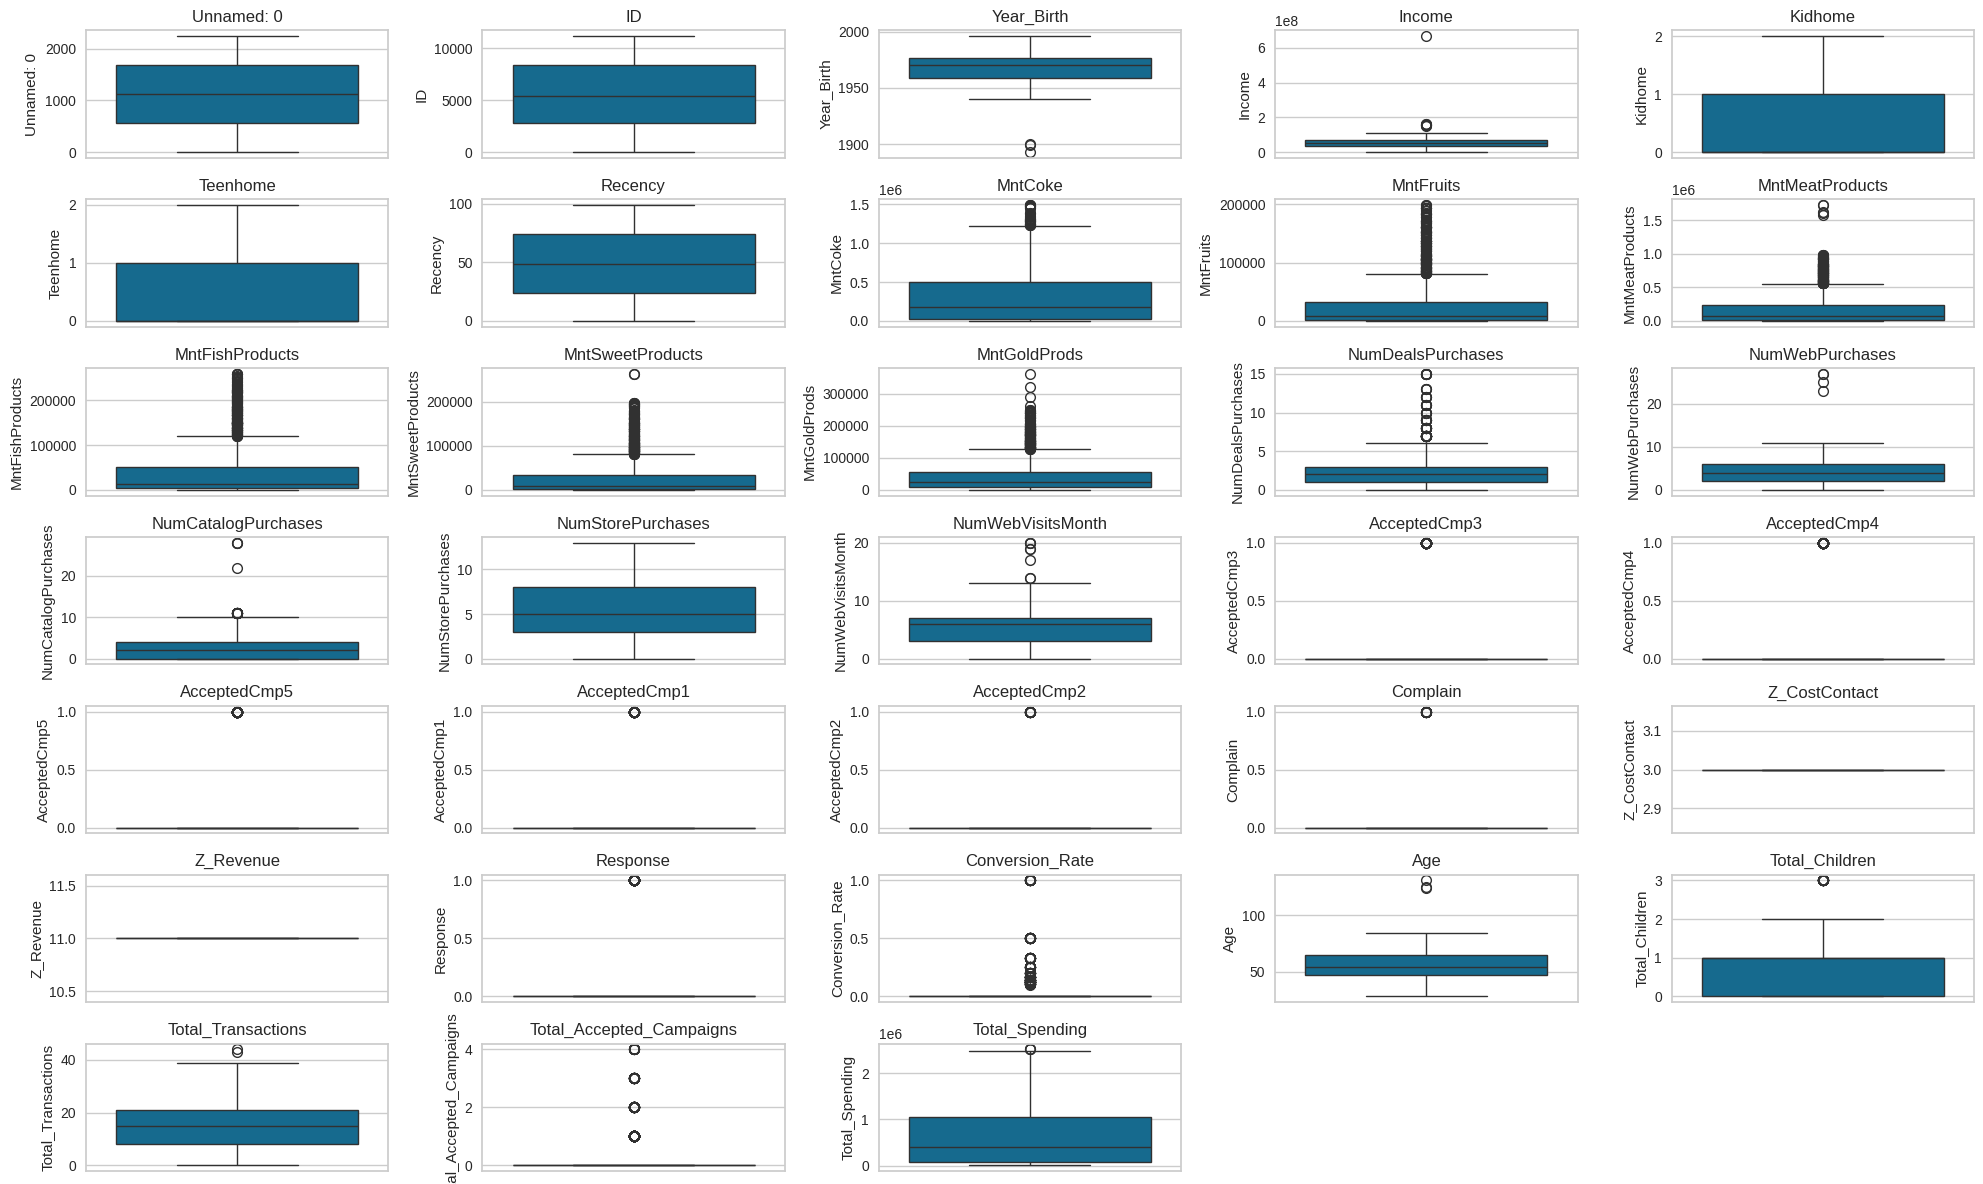

In [ ]:
# Cek outlier Feature Numeric
plt.figure(figsize=(20, 12))
for i in range(len(num)):
    plt.subplot(7, 5, i + 1)
    sns.boxplot(y=df[num[i]], orient='v')
    plt.title(num[i])
    plt.tight_layout()

plt.show()

Key Takeaways:
- Data Cenderung memiliki outlier

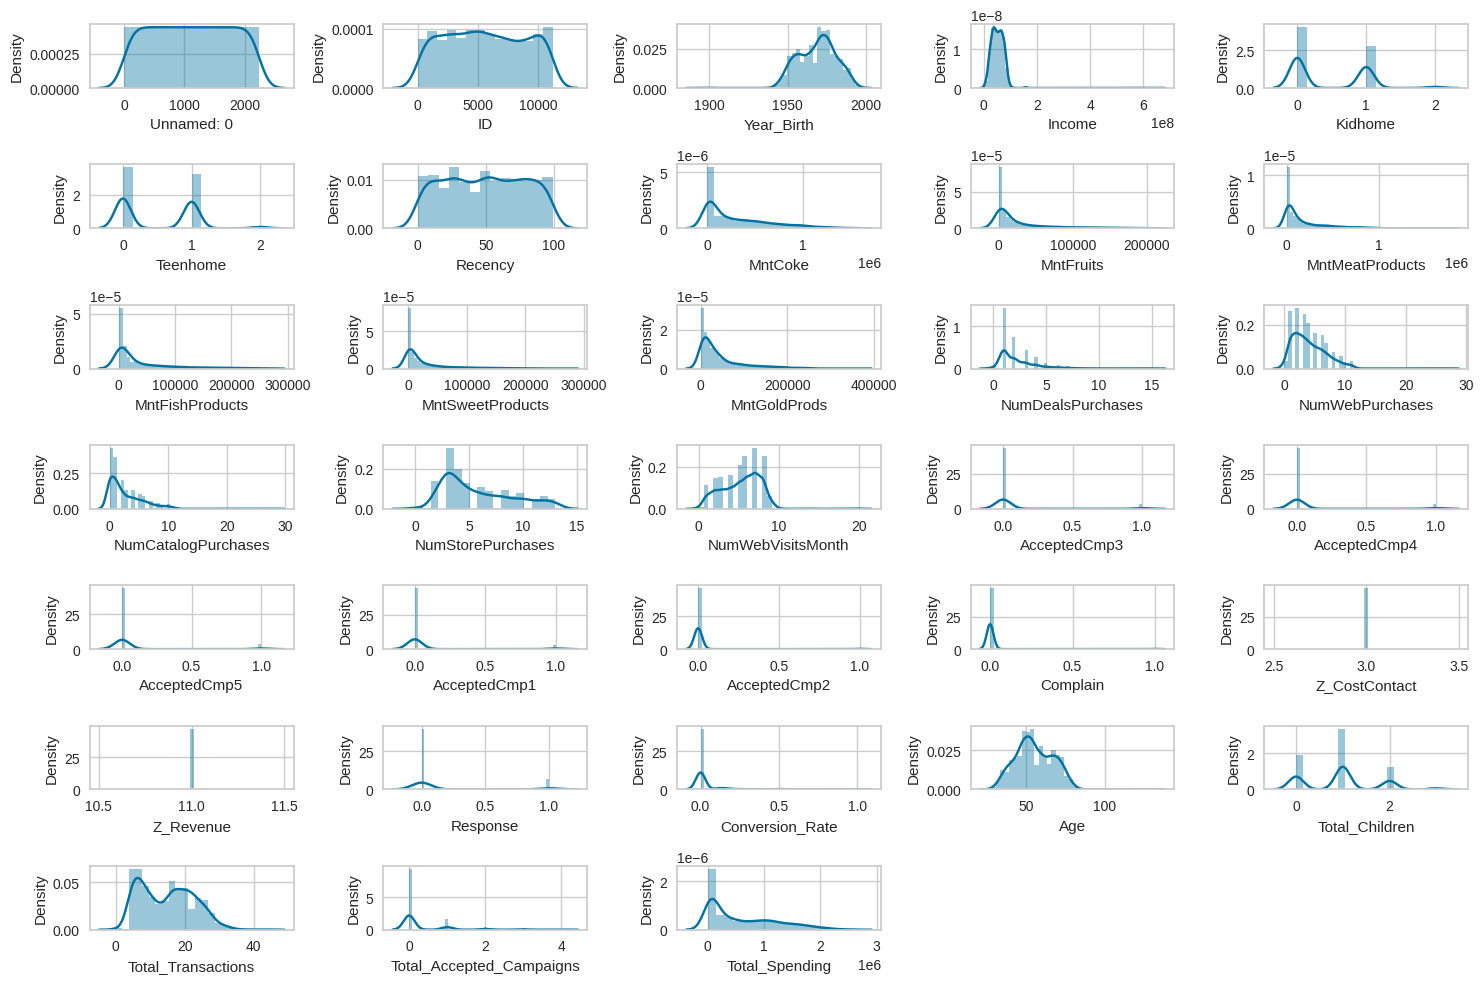

In [ ]:
# Distribusi Feature Numeric
plt.figure(figsize=(15, 10))
for i in range(0, len(num)):
    plt.subplot(7, 5, i+1)
    sns.distplot(df[num[i]])
    plt.tight_layout()

Key Takeaways:
- Rata-rata fetaure berdistribusi positively skewed

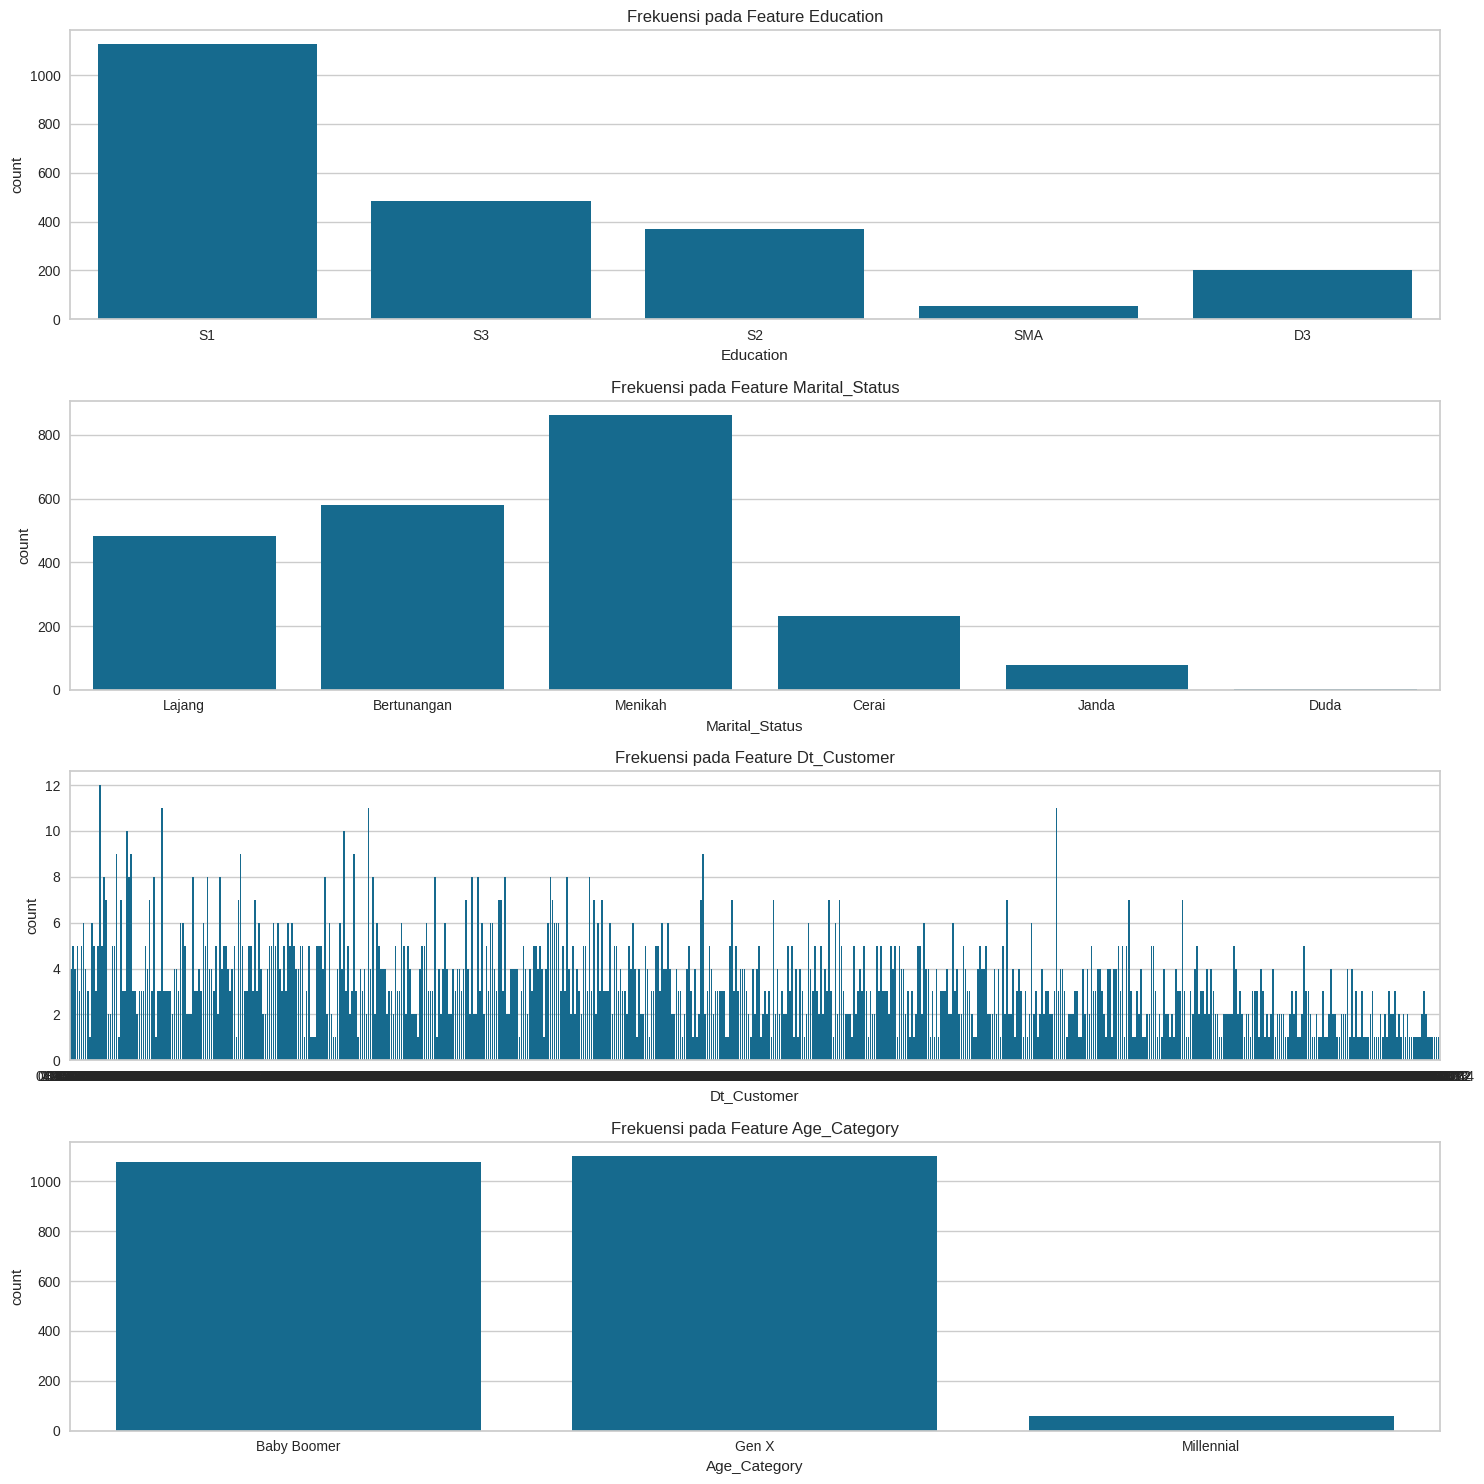

In [ ]:
# Distriusi feature kategorikal
plt.figure(figsize=(15, 15))
for i in range(len(cat)):
    plt.subplot(4, 1, i+1)
    sns.countplot(x=df[cat[i]])
    plt.title(f'Frekuensi pada Feature {cat[i]}')
    plt.tight_layout()

plt.show()

Key Takeaways:
- Education di dominasi oleh S1
- Marital_status di dominasi oleh Menikah
- Age Catgory Baby Boomer dan Gen X hampir sama banyaknya, sendagkan Millenial sangat sedikit

### Multivariate Analysis

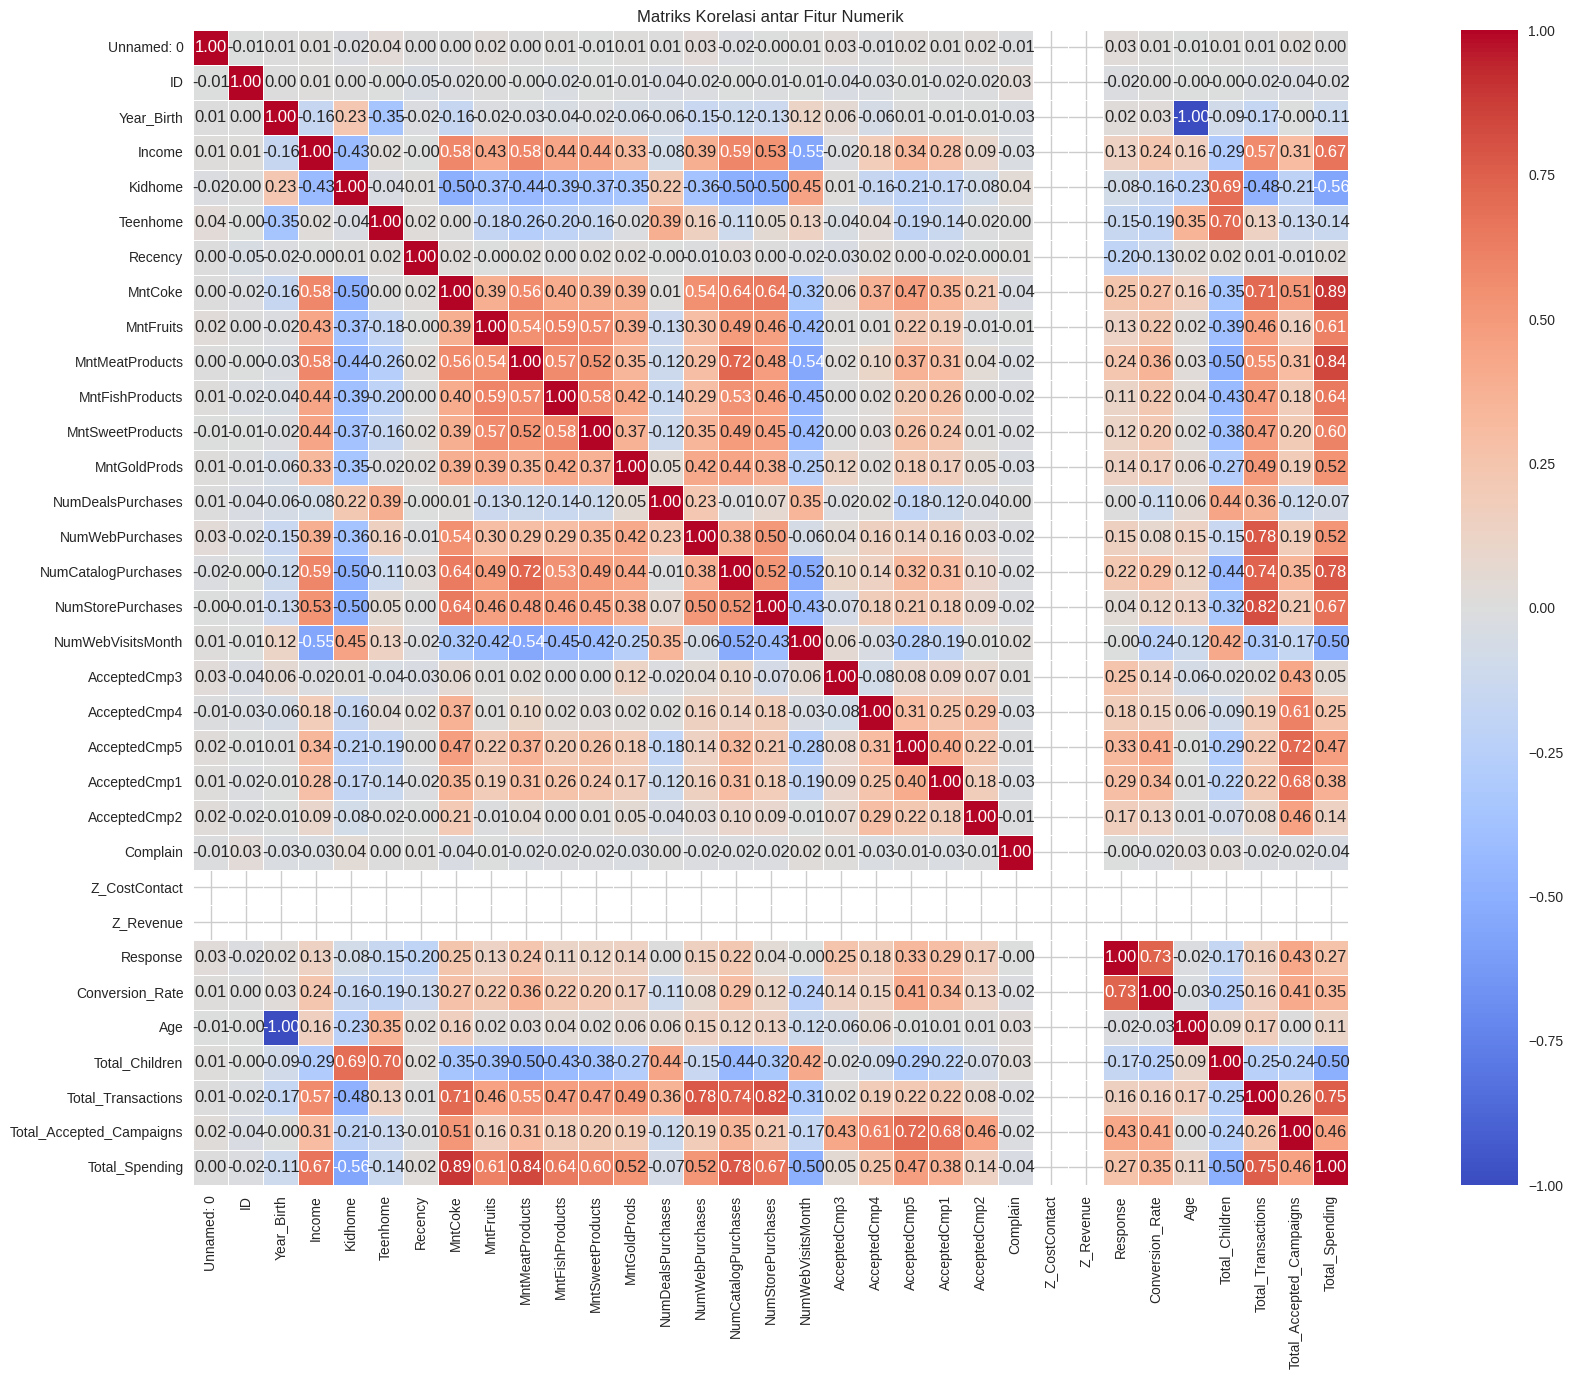

In [ ]:
# Menghitung korelasi antar fitur numerik
corr_matrix = df[num].corr()

# Plotting heatmap untuk visualisasi korelasi
plt.figure(figsize=(29, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=.5)
plt.title('Matriks Korelasi antar Fitur Numerik')
plt.show()

Key Takeaways:

- Feature **MntCoke**, **MntMeatProducts**, **MntFruits**, **MntFishProducts**, **MntSweetProducts**, dan **MntGoldProds** menunjukkan korelasi positif yang kuat satu sama lain, yang menunjukkan bahwa pelanggan yang spending di satu kategori cenderung spending lebih banyak di kategori lainnya juga.

- Feature **Total_Spending** memiliki korelasi positif dengan **NumCatalogPurchases** dan **NumStorePurchases**, yang mengindikasikan bahwa pelanggan lebih banyak melakukan pembelian melalui katalog dan di toko.

- Feature **Total_Accepted_Campaigns**  memiliki korelasi positif dengan **Conversion_Rate** dan **Response**, menunjukkan bahwa pelanggan yang menerima lebih banyak penawaran cenderung memiliki tingkat konversi yang lebih tinggi.

- Feature **Age** memiliki korelasi negatif dengan **Kidhome** dan **Teenhome**, yang mungkin menunjukkan bahwa pelanggan yang lebih muda lebih cenderung memiliki anak-anak atau remaja di rumah.

- Feature **NumWebVisitsMonth** memiliki korelasi negatif dengan **Income** dan **Total_Spending**, diketahui bahwa pelanggan dengan pendapatan lebih tinggi dan pengeluaran lebih banyak cenderung mengunjungi situs web perusahaan lebih sedikit.

## b. Correlation of Conversion Rate with Income, Total Spending and Age

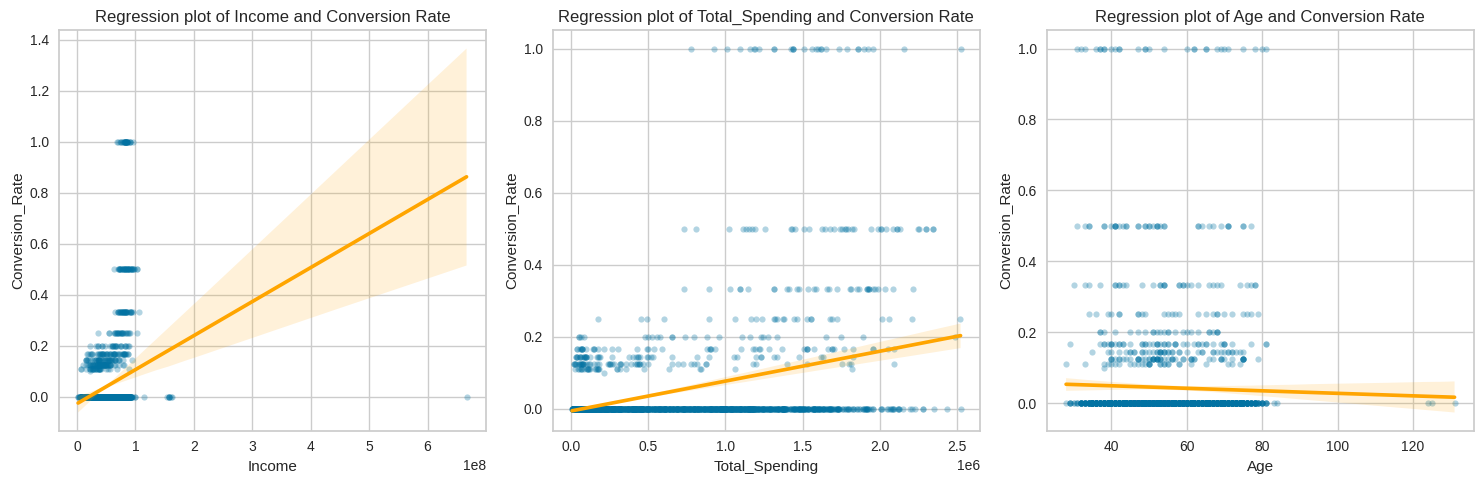

In [ ]:
variables = ['Income', 'Total_Spending', 'Age']

plt.figure(figsize=(15, 5))

for var in range(0, len(variables)):
    plt.subplot(1, 3, var + 1)
    sns.regplot(x=variables[var], y='Conversion_Rate', data=df, scatter_kws={'s': 20, 'alpha': 0.3},
                line_kws={'color': 'orange'}).set(title=f'Regression plot of {variables[var]} and Conversion Rate')
    plt.tight_layout()

plt.show()

Key Takeaways:
- Terdapat korelasi positif pada Income dan Total_Spending terhadap conveersion rate, hal ini berarti semakin tinggi Income atau Total Spending maka semakin tinggi juga tingkat konversi atau pembelian dari customer
- Korelasi umur dengan Conversion Rate tidak menunjukkan adanya korelasi atau netral, hal ini berarti umur tidak mempengaruhi conversion rate.

## c. Correlation of Total Spending with Total Transaction and Marital Status

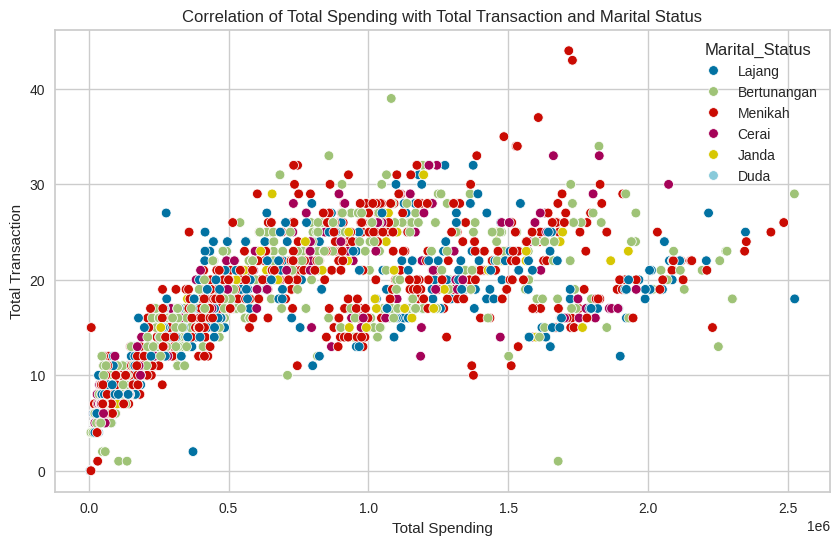

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Spending', y='Total_Transactions', data=df, hue='Marital_Status')
plt.title('Correlation of Total Spending with Total Transaction and Marital Status')
plt.xlabel('Total Spending')
plt.ylabel('Total Transaction')
plt.show()

Key Takeaways:
- Total Transaction paling banyak dilakukan oleh customer dengan kategori Menikah
- Total Spending tertinggi dilakukan oleh customer dengan kategori Menikah
- Sebaran data sangat variatif, semua kategori tersebar secara cukup merata.

## d. Total Spending Based on Total Child

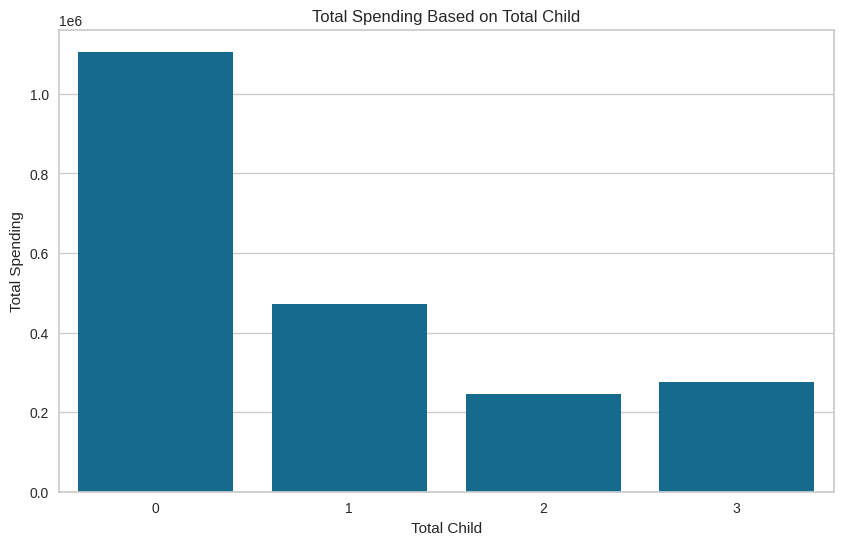

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Total_Children', y='Total_Spending', data=df, ci=None)
plt.title('Total Spending Based on Total Child')
plt.xlabel('Total Child')
plt.ylabel('Total Spending')
plt.show()

Key Takeaways:
- Customer yang sudah menikah tapi belum punya anak (0) lebih banyak pengeluarannya dibandingkan yang sudah punya anak, semakin banyak anak yang dimiliki, semakin sedikit pengeluarannya.

## e. Purchase Method

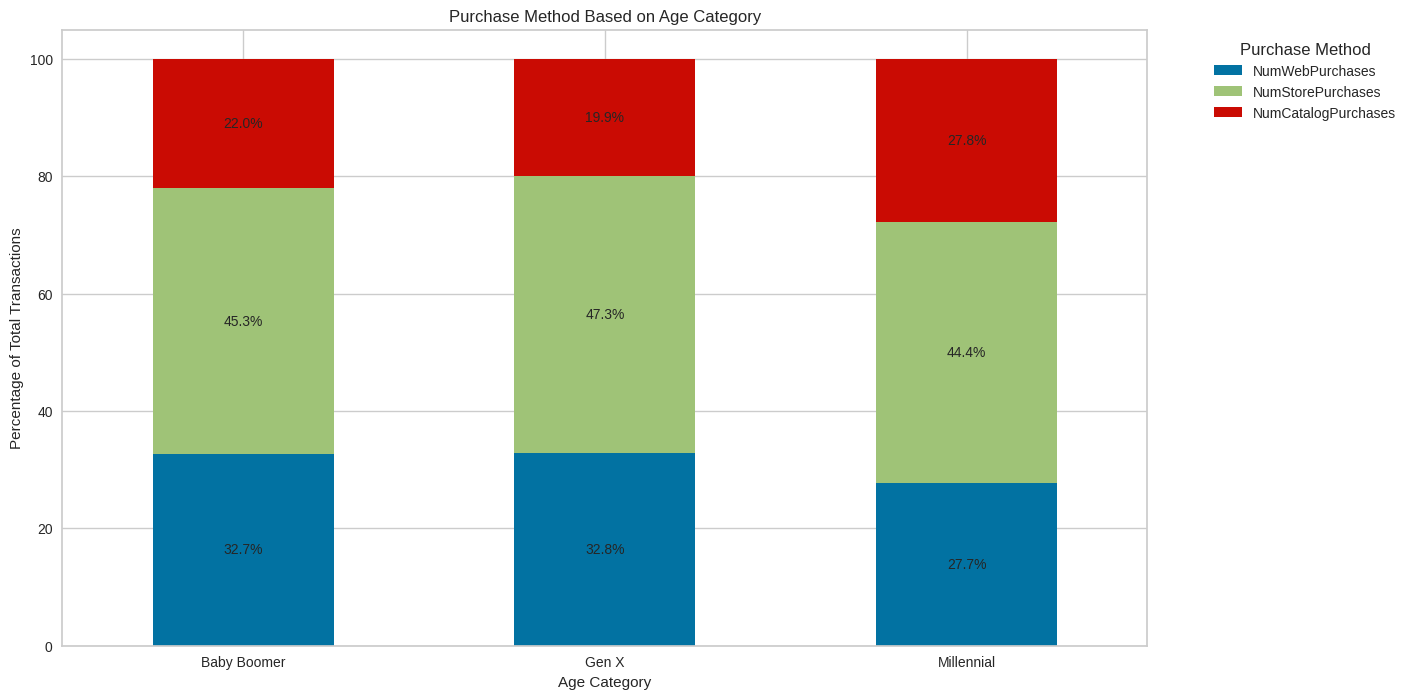

In [ ]:
df_grouped = df.groupby('Age_Category').agg({
    'NumWebPurchases': 'sum',
    'NumStorePurchases': 'sum',
    'NumCatalogPurchases': 'sum'
})

df_grouped_percentage = df_grouped.div(df_grouped.sum(axis=1), axis=0) * 100
fig, ax = plt.subplots(figsize=(14, 8))  # Memperbesar ukuran gambar
df_grouped_percentage.plot(kind='bar', stacked=True, ax=ax)

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10)

plt.title('Purchase Method Based on Age Category')
plt.xlabel('Age Category')
plt.ylabel('Percentage of Total Transactions')
plt.xticks(rotation=0)
plt.legend(title='Purchase Method')
plt.legend(title='Purchase Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Key Takeaways:
- Semua customer paling banyak melakukan transaksi dengan metode pembelian melalui Store
- Untuk pembelian melalui Catalog lebih disukai oleh Customer dengan kategori Millenial

# 6. Data Cleansing

## Handling Missing Value and Duplicated Data

In [ ]:
# Cek Missing value
df.isna().sum()

Unnamed: 0                   0
ID                           0
Year_Birth                   0
Education                    0
Marital_Status               0
Income                      24
Kidhome                      0
Teenhome                     0
Dt_Customer                  0
Recency                      0
MntCoke                      0
MntFruits                    0
MntMeatProducts              0
MntFishProducts              0
MntSweetProducts             0
MntGoldProds                 0
NumDealsPurchases            0
NumWebPurchases              0
NumCatalogPurchases          0
NumStorePurchases            0
NumWebVisitsMonth            0
AcceptedCmp3                 0
AcceptedCmp4                 0
AcceptedCmp5                 0
AcceptedCmp1                 0
AcceptedCmp2                 0
Complain                     0
Z_CostContact                0
Z_Revenue                    0
Response                     0
Conversion_Rate              0
Age                          0
Age_Cate

- Terdapat null value pada Feature **Income** sebanyak 24 baris
- Solusi:
  - Menghapus baris null, karena jumlahnya hanya sedikit

In [ ]:
df.dropna(subset=['Income'], inplace=True)

In [ ]:
# Cek Duplikat data
df.duplicated().any()

False

- Tidak terdapat Data Dupliakt

## Change Data Type

In [ ]:
# Mengubah tipe data Datetime
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
print(df['Dt_Customer'].dtypes)

datetime64[ns]


## Handling Outlier

In [ ]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))

cols_to_filter = ['Year_Birth', 'Income', 'MntMeatProducts', 'MntSweetProducts', 'NumWebPurchases', 'NumCatalogPurchases']

for col in cols_to_filter:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df[col] >= low_limit) & (df[col] <= high_limit)) & filtered_entries

df2 = df[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df2)}')

Jumlah baris sebelum memfilter outlier: 2216
Jumlah baris setelah memfilter outlier: 1840


In [ ]:
# Pengelompokkan Feature
num = df2.select_dtypes(include=['float64', 'int64']).columns
cat = df2.select_dtypes(include=['object']).columns

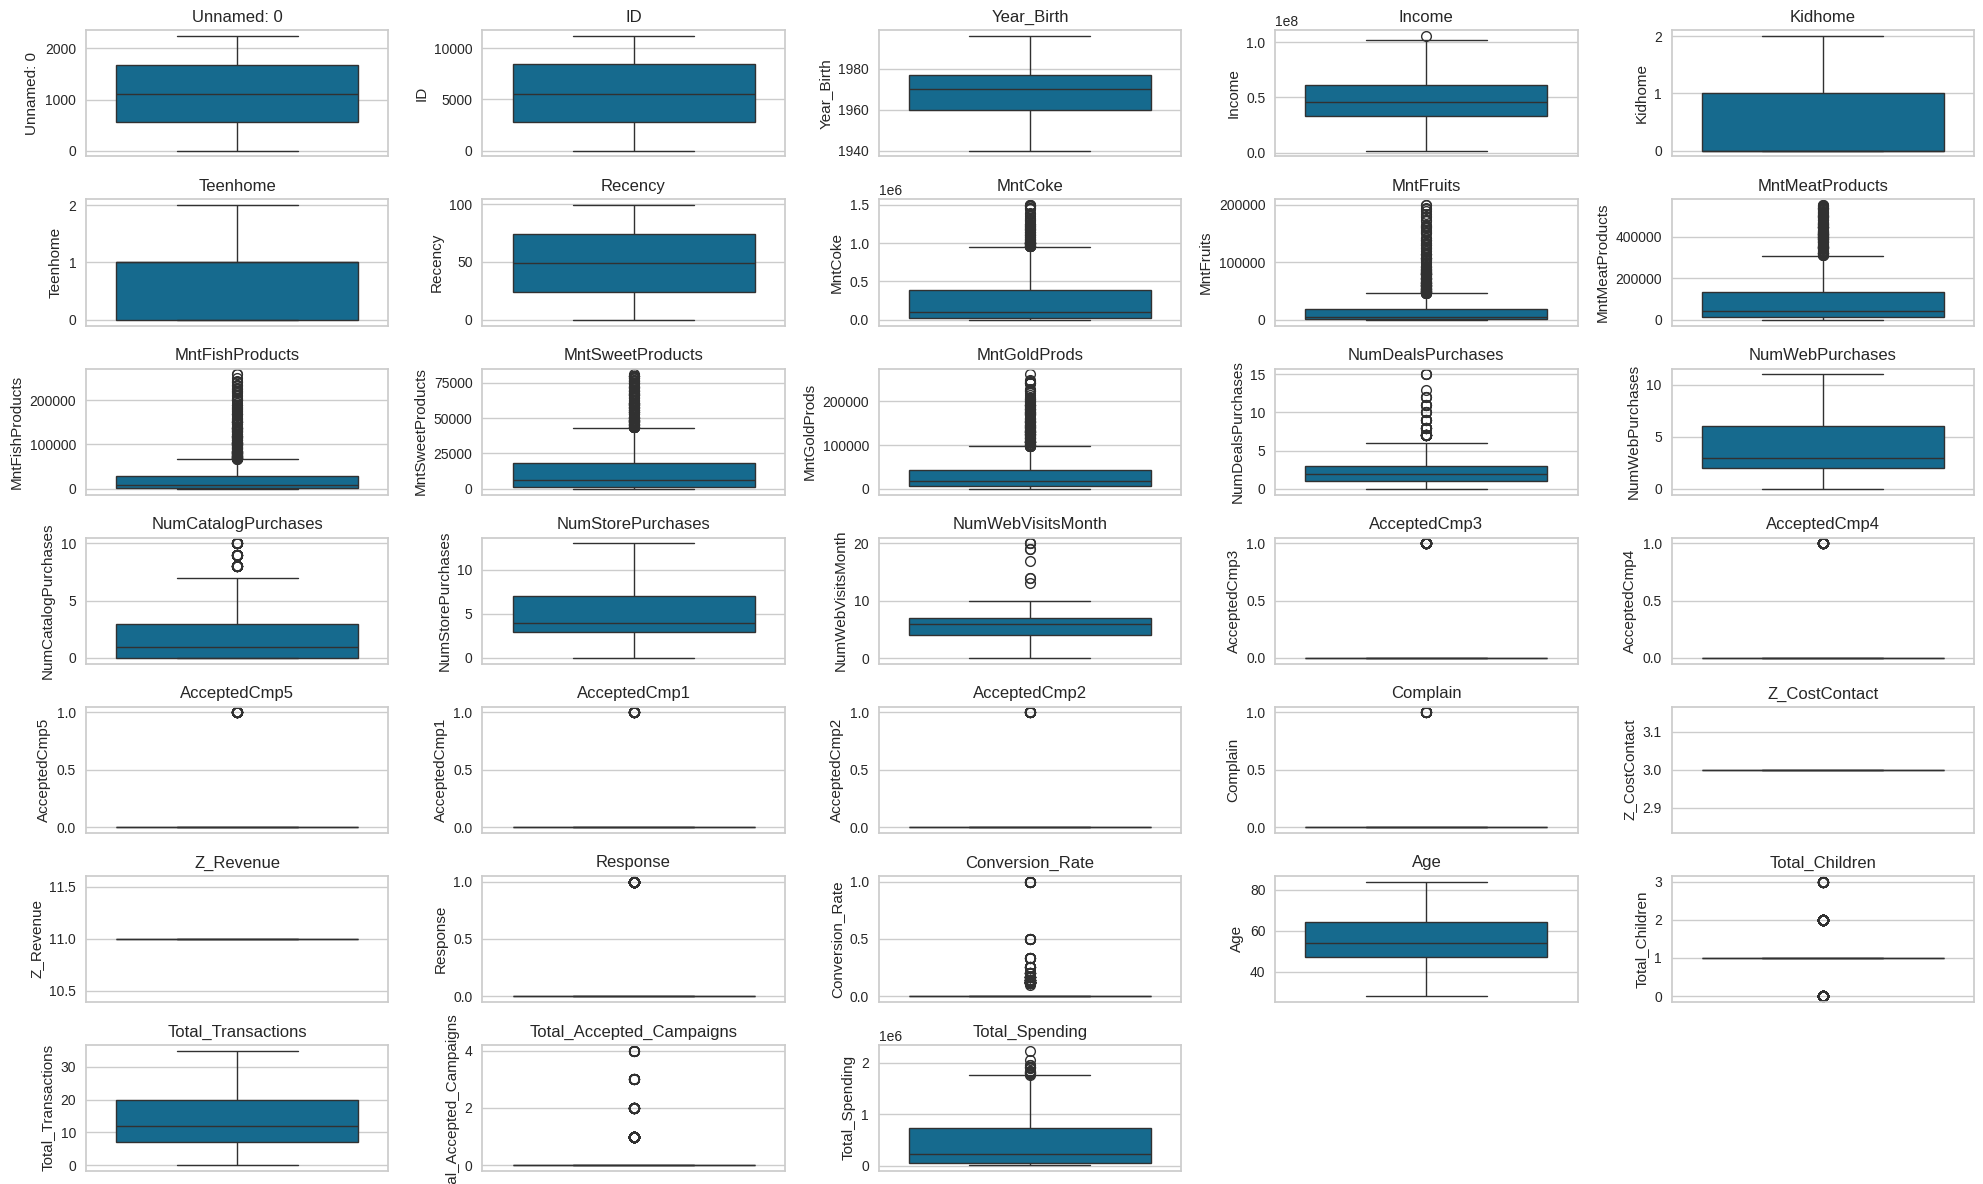

In [ ]:
# Cek outlier Setelah di filter
plt.figure(figsize=(20, 12))
for i in range(len(num)):
    plt.subplot(7, 5, i + 1)
    sns.boxplot(y=df2[num[i]], orient='v')
    plt.title(num[i])
    plt.tight_layout()

plt.show()

## Removing Feature

In [ ]:
# Menghapus feature
df.drop(['Unnamed: 0', 'ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)
print(df.columns)

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntCoke', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response', 'Conversion_Rate', 'Age',
       'Age_Category', 'Total_Children', 'Total_Transactions',
       'Total_Accepted_Campaigns', 'Total_Spending'],
      dtype='object')


# 7. Feature Encoding

## Education

In [ ]:
# Mapping untuk fitur "Education"
mapping_education = {'SMA': 0, 'D3': 1, 'S1': 2, 'S2': 3, 'S3': 4}

df2['education_encd'] = df2['Education'].map(mapping_education)
df2.head()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,Z_Revenue,Response,Conversion_Rate,Age,Age_Category,Total_Children,Total_Transactions,Total_Accepted_Campaigns,Total_Spending,education_encd
1,1,2174,1954,S1,Lajang,46344000.0,1,1,2014-03-08,38,...,11,0,0.0,70,Baby Boomer,2,6,0,27000,2
2,2,4141,1965,S1,Bertunangan,71613000.0,0,0,2013-08-21,26,...,11,0,0.0,59,Baby Boomer,0,21,0,776000,2
3,3,6182,1984,S1,Bertunangan,26646000.0,1,0,2014-02-10,26,...,11,0,0.0,40,Gen X,1,8,0,53000,2
4,4,5324,1981,S3,Menikah,58293000.0,1,0,2014-01-19,94,...,11,0,0.0,43,Gen X,1,19,0,422000,4
5,5,7446,1967,S2,Bertunangan,62513000.0,0,1,2013-09-09,16,...,11,0,0.0,57,Baby Boomer,1,22,0,716000,3


# 8. Feature Transformation

In [ ]:
df3 = df2.copy()

## Standardization

In [ ]:
# Hapus Feature yang tidak diperlukan untuk standardisasi
columns_drop = ['Year_Birth', 'Education', 'Marital_Status', 'Age_Category', 'Dt_Customer']
df3.drop(columns=columns_drop, inplace=True)
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1840 entries, 1 to 2239
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1840 non-null   int64  
 1   ID                        1840 non-null   int64  
 2   Income                    1840 non-null   float64
 3   Kidhome                   1840 non-null   int64  
 4   Teenhome                  1840 non-null   int64  
 5   Recency                   1840 non-null   int64  
 6   MntCoke                   1840 non-null   int64  
 7   MntFruits                 1840 non-null   int64  
 8   MntMeatProducts           1840 non-null   int64  
 9   MntFishProducts           1840 non-null   int64  
 10  MntSweetProducts          1840 non-null   int64  
 11  MntGoldProds              1840 non-null   int64  
 12  NumDealsPurchases         1840 non-null   int64  
 13  NumWebPurchases           1840 non-null   int64  
 14  NumCatalogPur

In [ ]:
# Pengelompokkan Feature
num = df3.select_dtypes(include=['float64', 'int64']).columns
cat = df3.select_dtypes(include=['object']).columns

In [ ]:
# Melakukan Standarisai
scaler = StandardScaler()
df_std = scaler.fit_transform(df3)

# 9. Modelling

## Principal Component Analysis

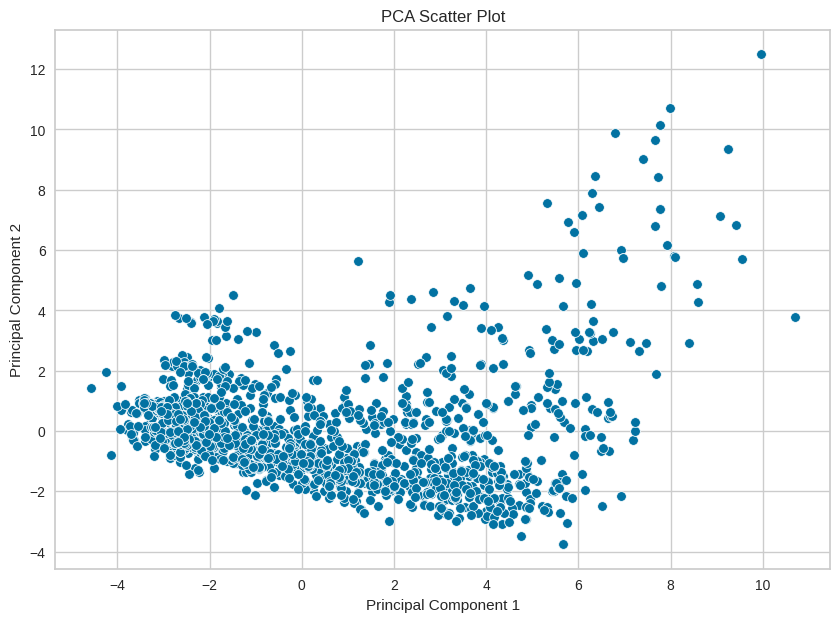

In [ ]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_std)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', palette='viridis')
plt.title('PCA Scatter Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
df_pca.head()

,PC1,PC2
0,-2.599627,-0.311507
1,2.933996,-1.298236
2,-2.654423,0.556221
3,0.664874,-1.074593
4,2.150036,-1.591310


## Elbow Method

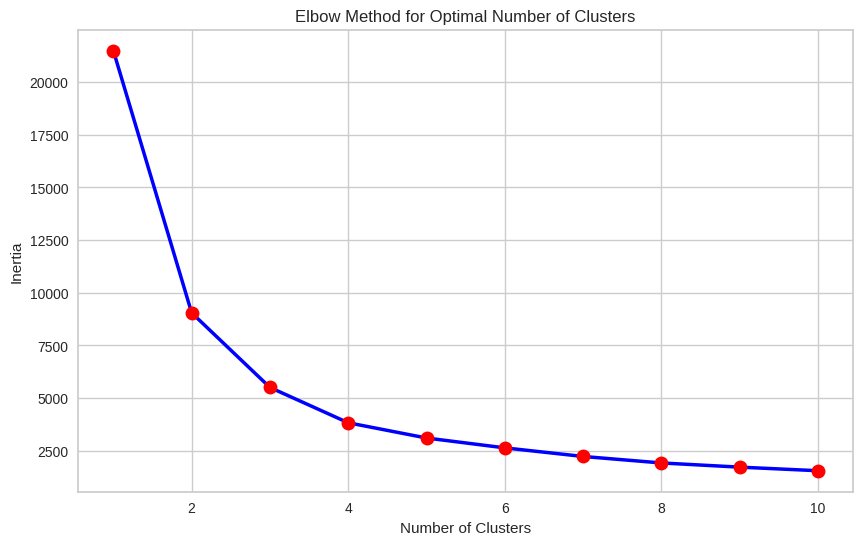

In [ ]:
cluster_range = range(1, 11)
inertia = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_pca)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, color='blue', linewidth=2.5, marker='o', markerfacecolor='red', markersize=10)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True)
plt.show()

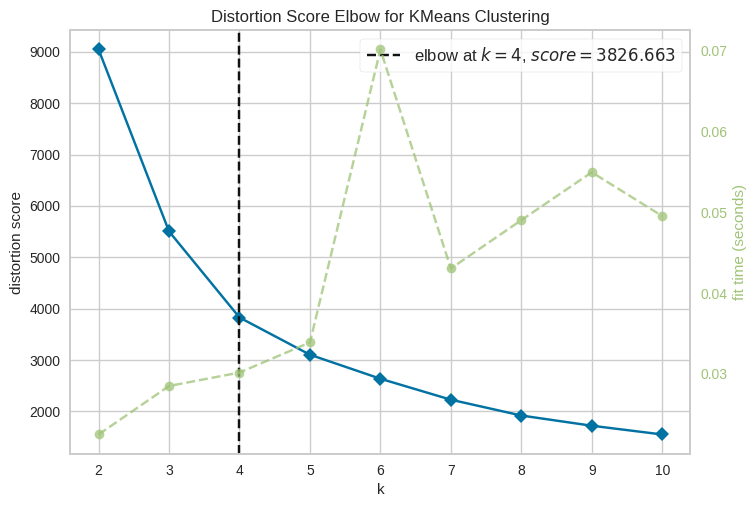

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# visualisasi dengan parameter distortion
from yellowbrick.cluster import KElbowVisualizer

# fit model
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, metric='distortion', timings=True, locate_elbow=True)
visualizer.fit(df_pca)
visualizer.show()

Key Takeaways:
- Berdasarkan Elbow Method dan Distortion Score diektahui jumlah cluster terbaik berada pada k=4

## Clustering K-Means

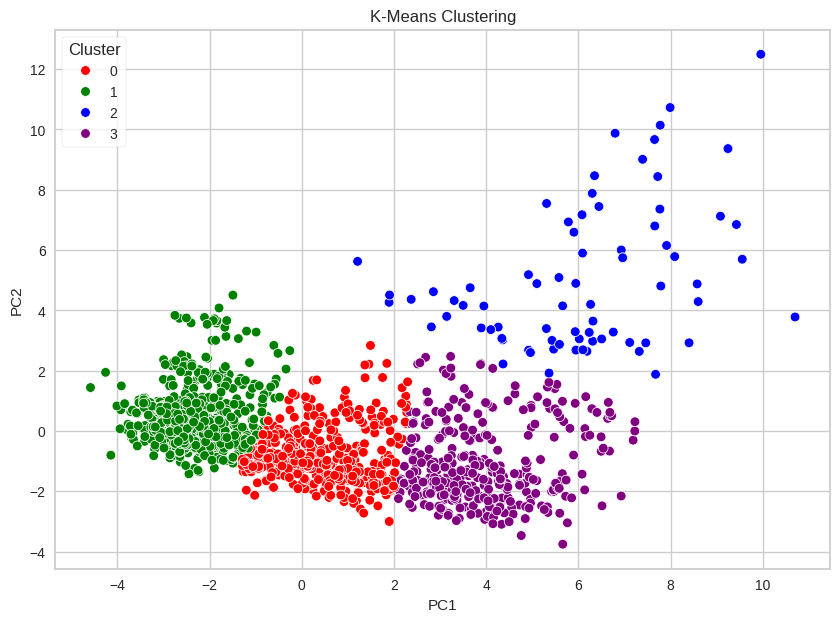

In [ ]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(df_pca)

# Menambahkan label cluster ke DataFrame
df_pca['Cluster'] = clusters

# Definisikan warna untuk setiap cluster
cluster_palette = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}

# Visualisasi hasil clustering dalam 2D dengan warna yang ditentukan
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette=cluster_palette)
plt.title('K-Means Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster', frameon=True)
plt.show()

## Silhouette Score

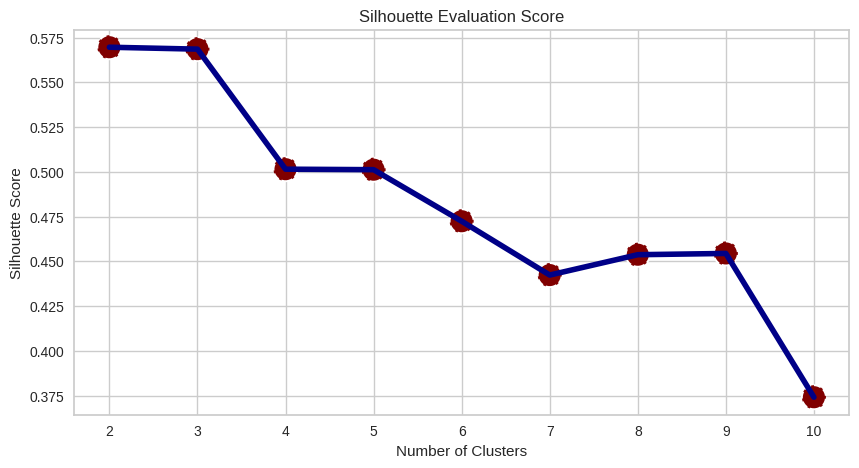

In [ ]:
# Range jumlah cluster yang akan diuji
range_n_clusters = list(range(2, 11))
arr_silhouette_score_euclidean = []

# Asumsikan df_pca adalah DataFrame yang telah direduksi dimensinya menggunakan PCA
for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=123).fit(df_pca[['PC1', 'PC2']])
    preds = kmeans.predict(df_pca[['PC1', 'PC2']])
    score_euclidean = silhouette_score(df_pca[['PC1', 'PC2']], preds, metric='euclidean')
    arr_silhouette_score_euclidean.append(score_euclidean)

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Silhouette Evaluation Score')
sns.lineplot(x=range_n_clusters, y=arr_silhouette_score_euclidean, color='#000087', linewidth=4)
sns.scatterplot(x=range_n_clusters, y=arr_silhouette_score_euclidean, s=300, color='#800000', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


Key Takeaways:
- Berdasarkan silhoutte score, cluster optimal di 4

# 10. Cluster Analysis

## Statistic Descriptive

In [ ]:
df3['Cluster'] = clusters

# Menghitung mean, median, min, max untuk fitur yang dipilih berdasarkan cluster
features = ['Income', 'Recency', 'Total_Spending', 'Total_Transactions', 'Conversion_Rate','Age']
cluster_stats = df3.groupby('Cluster')[features].agg(['mean', 'median', 'min', 'max'])

print(cluster_stats)

               Income                                         Recency         \
                 mean      median         min          max       mean median   
Cluster                                                                        
0        5.279318e+07  53127500.0  24279000.0   79803000.0  49.375556   50.5   
1        3.283598e+07  33347000.0   1730000.0   64587000.0  48.250545   48.0   
2        7.541105e+07  78028000.0  37929000.0  105471000.0  43.903614   40.0   
3        6.740618e+07  67353000.0  32632000.0   93404000.0  49.311054   51.0   

                Total_Spending             ... Total_Transactions      \
        min max           mean     median  ...                min max   
Cluster                                    ...                          
0         0  98   4.636311e+05   430000.0  ...                  7  32   
1         0  99   7.759586e+04    57000.0  ...                  0  18   
2         0  99   1.351422e+06  1376000.0  ...                 10  32   
3

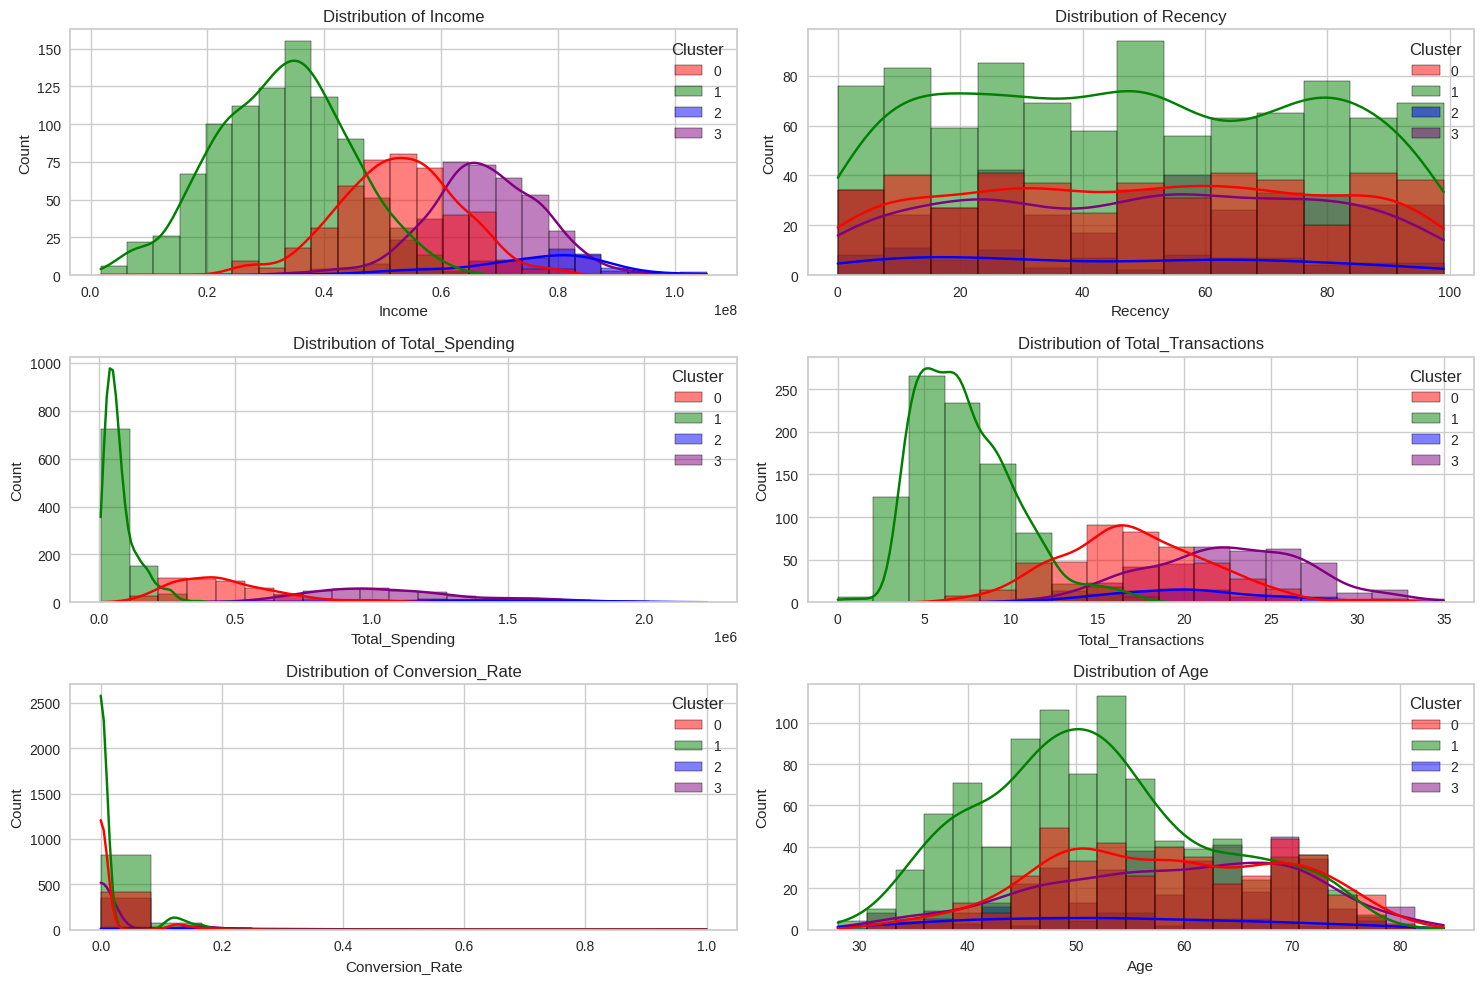

In [ ]:
# Visualisasi distribusi fitur dengan histogram
features = ['Income', 'Recency', 'Total_Spending', 'Total_Transactions', 'Conversion_Rate', 'Age']
cluster_palette = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df3, x=feature, hue='Cluster', kde=True, palette=cluster_palette)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


Key Takeaways:

- Pada Cluster 0 diketahui bahwa angka transaksi dan spending tertinggi, dengan rata-rata 17 transaksi dan Rp. 463,631 per bulan. Pendapatan di cluster ini cukup tinggi, rata-rata sebesar Rp. 52,793,177 per tahun. Conversion rate di cluster ini termasuk rendah, yaitu 1.12%. rata-rata umur di cluster ini berusia 58 tahun

- Pada Cluster 1 diketahui bahwa angka transaksi dan spending terendah, dengan rata-rata hanya 7 transaksi dan Rp. 77,596 per bulan. Pendapatan di cluster ini terendah, rata-rata sebesar Rp. 32,835,981 per tahun. Conversion rate di cluster ini termasuk rendah, yaitu 1.36%. rata-rata umur di cluster ini berusia 51 tahun

- Pada Cluster 2 diketahui bahwa angka transaksi dan spending tertinggi, dengan rata-rata 20 transaksi dan Rp. 1,351,422 per bulan. Pendapatan di cluster ini tertinggi, rata-rata sebesar Rp. 75,411,048 per tahun. Conversion rate di cluster ini yang paling tinggi, yaitu 27.68%. rata-rata umur di cluster ini berusia 53 tahun

- Pada Cluster 3 diketahui bahwa angka transaksi dan spending sedang, dengan rata-rata 23 transaksi dan Rp. 1,081,157 per bulan. Pendapatan di cluster ini cukup tinggi, rata-rata sebesar Rp. 67,406,177 per tahun. Conversion rate di cluster ini tertinggi kedua setelah cluster 2, yaitu 2.36%. rata-rata umur di cluster ini berusia 58 tahun



## Cluster Category

In [ ]:
import pandas as pd

# Menambahkan kolom Cluster ke df3
df3['Cluster'] = clusters

# Menghitung rata-rata nilai untuk setiap cluster
cluster_summary = df3.groupby('Cluster')[['Income', 'Total_Spending', 'Total_Transactions', 'Conversion_Rate']].mean()

# Menentukan kategori berdasarkan quantiles
def determine_category(value, quantiles):
    if value <= quantiles[0.25]:
        return 'Churn Potential'
    elif value <= quantiles[0.50]:
        return 'Low Spender'
    elif value <= quantiles[0.75]:
        return 'Medium Spender'
    else:
        return 'High Spender'

# Menentukan quantiles
income_quantiles = cluster_summary['Income'].quantile([0.25, 0.50, 0.75])
spending_quantiles = cluster_summary['Total_Spending'].quantile([0.25, 0.50, 0.75])
transactions_quantiles = cluster_summary['Total_Transactions'].quantile([0.25, 0.50, 0.75])
conversion_rate_quantiles = cluster_summary['Conversion_Rate'].quantile([0.25, 0.50, 0.75])

# Menambahkan kategori ke cluster_summary
cluster_summary['Customer_Income_Category'] = cluster_summary['Income'].apply(determine_category, args=(income_quantiles,))
cluster_summary['Customer_Spending_Category'] = cluster_summary['Total_Spending'].apply(determine_category, args=(spending_quantiles,))
cluster_summary['Customer_Transaction_Category'] = cluster_summary['Total_Transactions'].apply(determine_category, args=(transactions_quantiles,))
cluster_summary['Customer_Conversion_Rate_Category'] = cluster_summary['Conversion_Rate'].apply(determine_category, args=(conversion_rate_quantiles,))
cluster_summary


,Income,Total_Spending,Total_Transactions,Conversion_Rate,Customer_Income_Category,Customer_Spending_Category,Customer_Transaction_Category,Customer_Conversion_Rate_Category
Cluster,,,,,,,,
0,5.279318e+07,4.636311e+05,17.188889,0.011181,Low Spender,Low Spender,Low Spender,Churn Potential
1,3.283598e+07,7.759586e+04,7.408497,0.013564,Churn Potential,Churn Potential,Churn Potential,Low Spender
2,7.541105e+07,1.351422e+06,20.349398,0.276812,High Spender,High Spender,Medium Spender,High Spender
3,6.740618e+07,1.081157e+06,22.506427,0.023583,Medium Spender,Medium Spender,High Spender,Medium Spender


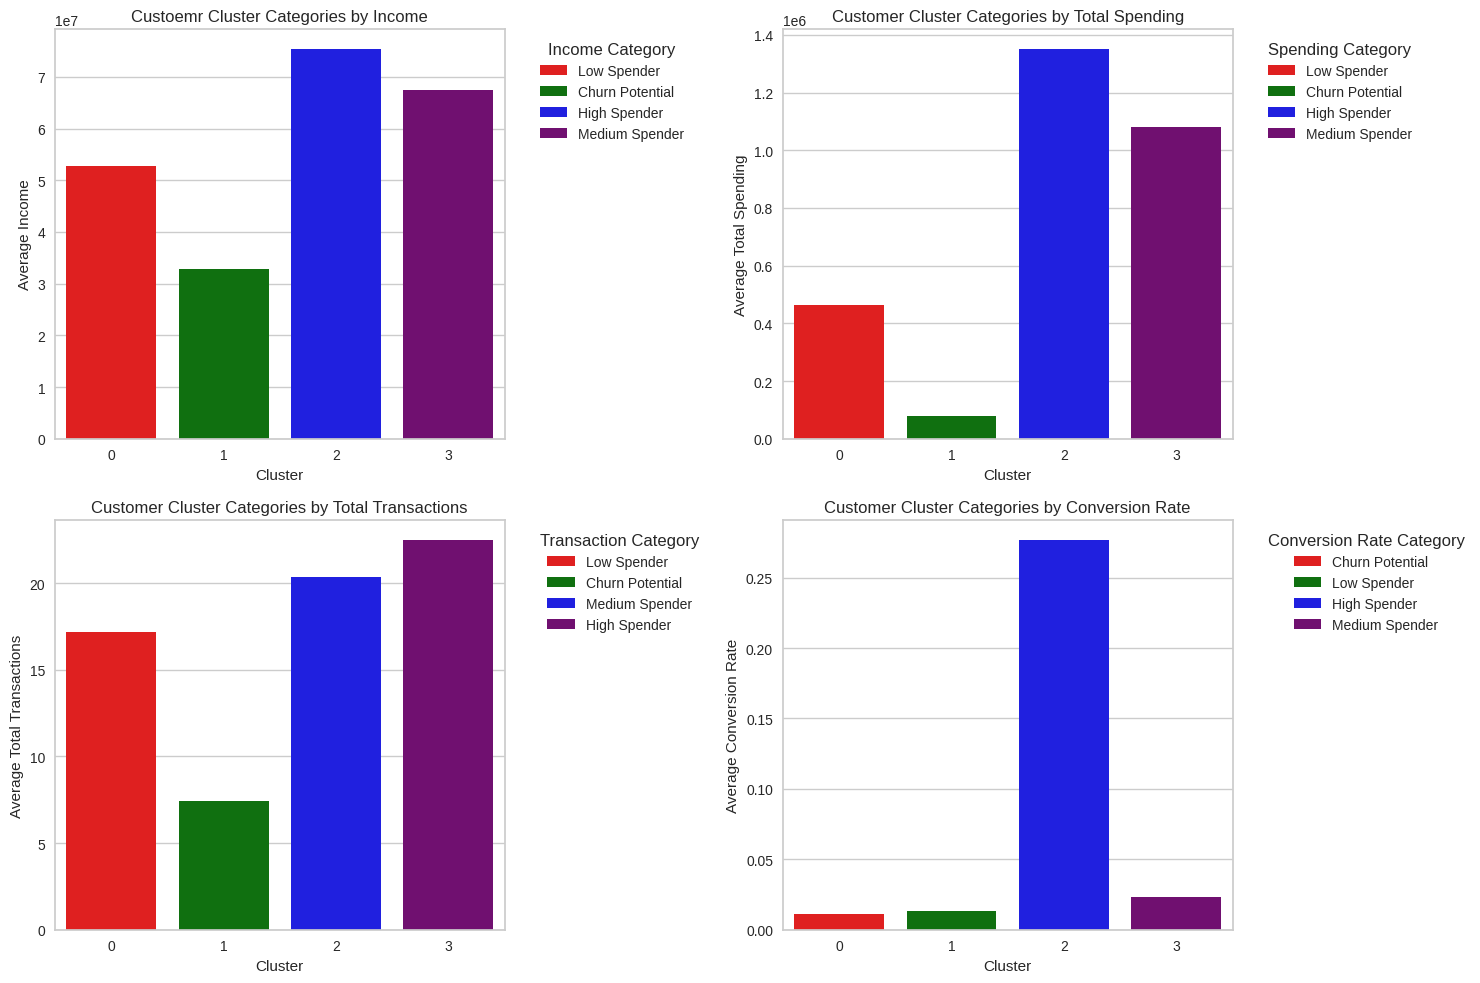

In [ ]:
plt.figure(figsize=(15, 10))

# Plot untuk kategori berdasarkan Income
plt.subplot(2, 2, 1)
sns.barplot(x=cluster_summary.index, y='Income', hue='Customer_Income_Category', data=cluster_summary, palette=['red', 'green', 'blue', 'purple'])
plt.title('Custoemr Cluster Categories by Income')
plt.xlabel('Cluster')
plt.ylabel('Average Income')
plt.legend(title='Income Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot untuk kategori berdasarkan Total Spending
plt.subplot(2, 2, 2)
sns.barplot(x=cluster_summary.index, y='Total_Spending', hue='Customer_Spending_Category', data=cluster_summary, palette=['red', 'green', 'blue', 'purple'])
plt.title('Customer Cluster Categories by Total Spending')
plt.xlabel('Cluster')
plt.ylabel('Average Total Spending')
plt.legend(title='Spending Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot untuk kategori berdasarkan Total Transactions
plt.subplot(2, 2, 3)
sns.barplot(x=cluster_summary.index, y='Total_Transactions', hue='Customer_Transaction_Category', data=cluster_summary, palette=['red', 'green', 'blue', 'purple'])
plt.title('Customer Cluster Categories by Total Transactions')
plt.xlabel('Cluster')
plt.ylabel('Average Total Transactions')
plt.legend(title='Transaction Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot untuk kategori berdasarkan Conversion Rate
plt.subplot(2, 2, 4)
sns.barplot(x=cluster_summary.index, y='Conversion_Rate', hue='Customer_Conversion_Rate_Category', data=cluster_summary, palette=['red', 'green', 'blue', 'purple'])
plt.title('Customer Cluster Categories by Conversion Rate')
plt.xlabel('Cluster')
plt.ylabel('Average Conversion Rate')
plt.legend(title='Conversion Rate Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Key Takeaways:

- Cluster 0 memiliki customer dengan pengeluaran dan transaksi yang relatif rendah, namun pendapatan yang cukup tinggi, menjadikannya kategori Low Spender.

- Cluster 1 memiliki customer dengan pendapatan, pengeluaran, dan transaksi yang paling rendah, serta conversion rate yang rendah, sehingga masuk dalam kategori Churn Potential.

- Cluster 2 memiliki customer kelompok customer dengan pendapatan, pengeluaran, dan transaksi yang tinggi, serta conversion rate yang sangat tinggi, menjadikannya kategori High Spender.

- Cluster 3 memiliki customer dengan pendapatan dan pengeluaran yang cukup tinggi serta jumlah transaksi yang tinggi, sehingga masuk dalam kategori Medium Spender.

## Total Customer

In [ ]:
total_customers_per_cluster = df3['Cluster'].value_counts().sort_index()

df_total_customers = pd.DataFrame({
    'Cluster': total_customers_per_cluster.index,
    'Total Customers': total_customers_per_cluster.values
})

df_total_customers['Percentage'] = (df_total_customers['Total Customers'] / df_total_customers['Total Customers'].sum()) * 100

cluster_labels = {0: 'Low Spender', 1: 'Churn Potential', 2: 'High Spender', 3: 'Medium Spender'}
df_total_customers['Cluster Label'] = df_total_customers['Cluster'].map(cluster_labels)
print(df_total_customers)

   Cluster  Total Customers  Percentage    Cluster Label
0        0              450   24.456522      Low Spender
1        1              918   49.891304  Churn Potential
2        2               83    4.510870     High Spender
3        3              389   21.141304   Medium Spender


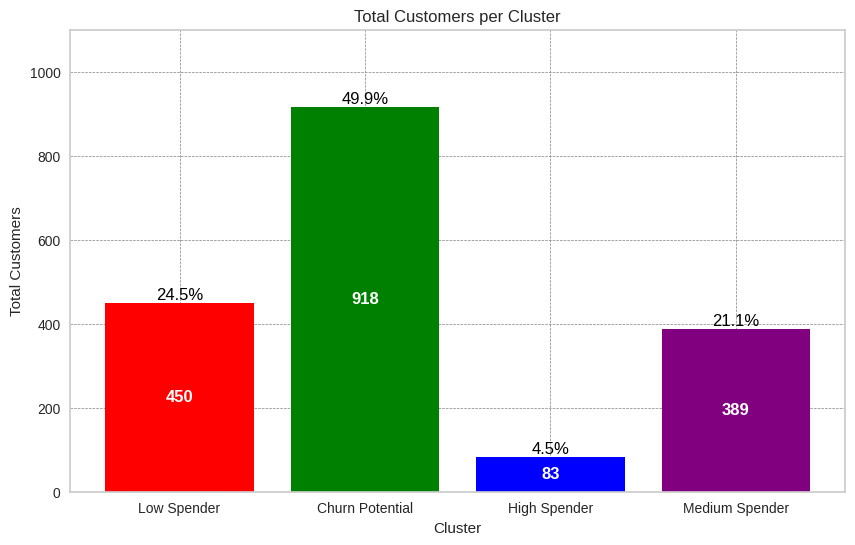

In [ ]:
cluster_colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(10, 6))
bars = plt.bar(x=df_total_customers['Cluster Label'], height=df_total_customers['Total Customers'], color=cluster_colors)
plt.title('Total Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Customers')
plt.xticks(df_total_customers['Cluster Label'])

for bar in bars:
    plt.gca().annotate(f'{int(bar.get_height())}',
                       (bar.get_x() + bar.get_width() / 2., bar.get_height() / 2.),
                       ha='center', va='center', color='white', fontsize=12, fontweight='bold')

for bar, y in zip(bars, df_total_customers['Percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 1, f'{y:.1f}%',
             ha='center', va='bottom', color='black', fontsize=12)

plt.ylim(0, df_total_customers['Total Customers'].max() * 1.2)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=0)
plt.gca().set_axisbelow(True)
plt.show()


Key Takeaways:
- Pada klasterirsasi, diketahui bahwa mayoritas customer berada pada cluster 1, dan cluster paling sedikit adalah cluster 2

## Income and Total Spending

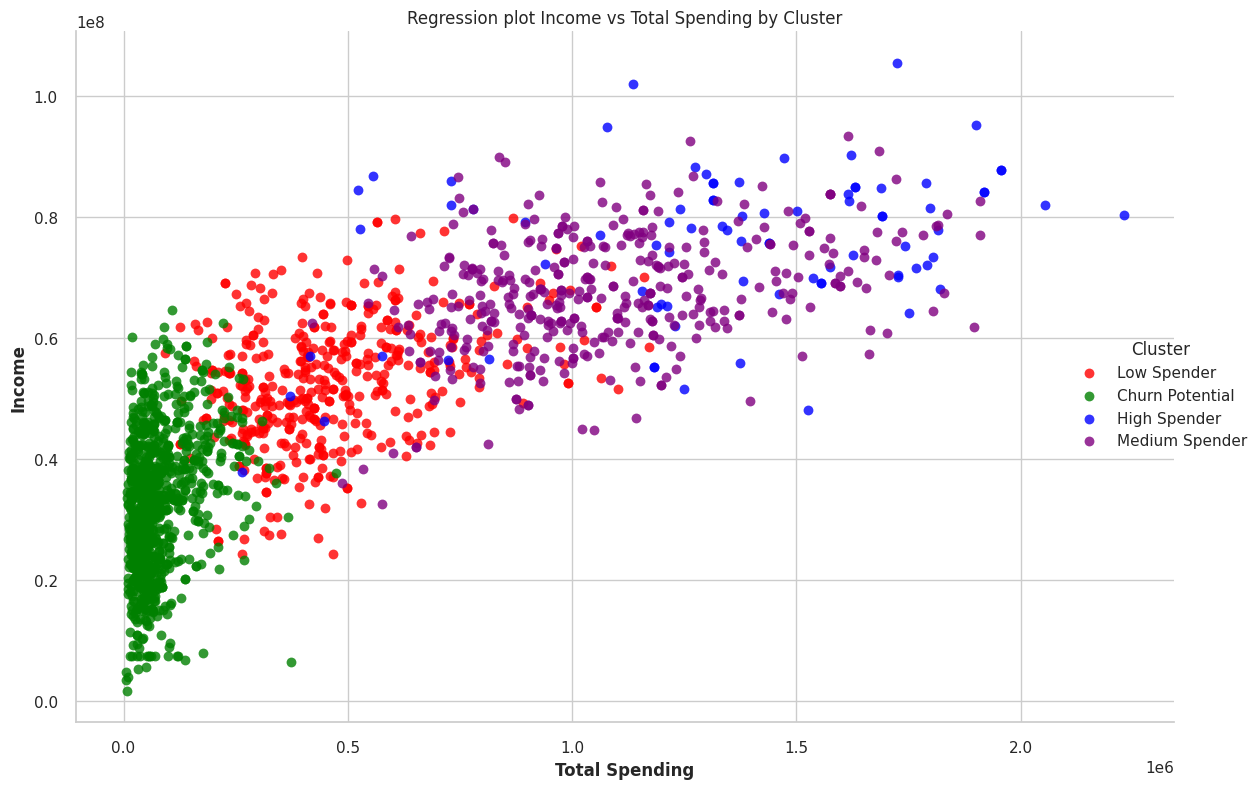

In [ ]:
color = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
df3['Cluster'] = df_pca['Cluster'].values

# Mapping cluster ke label deskriptif
cluster_labels = {0: 'Low Spender', 1: 'Churn Potential', 2: 'High Spender', 3: 'Medium Spender'}
df3['Cluster_Label'] = df3['Cluster'].map(cluster_labels)

# Plot regresi
sns.set(style="whitegrid")
plot = sns.lmplot(
    y='Income', x='Total_Spending', hue='Cluster', fit_reg=False, data=df3,
    palette=color, height=8, aspect=1.5, scatter_kws={'s':50, 'alpha':0.8}
)

# Atur judul dan label
plot.set(title='Regression plot Income vs Total Spending by Cluster')
plt.xlabel('Total Spending', fontweight='bold')
plt.ylabel('Income', fontweight='bold')

# Ganti label legenda
new_labels = [cluster_labels[cluster] for cluster in sorted(cluster_labels.keys())]
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)

plt.show()

Key Takeaways:
- Semakin tinggi income, semakin tinggi juga Total Spending yang dilakukan oleh customer

## Age Category

<Figure size 1000x600 with 0 Axes>

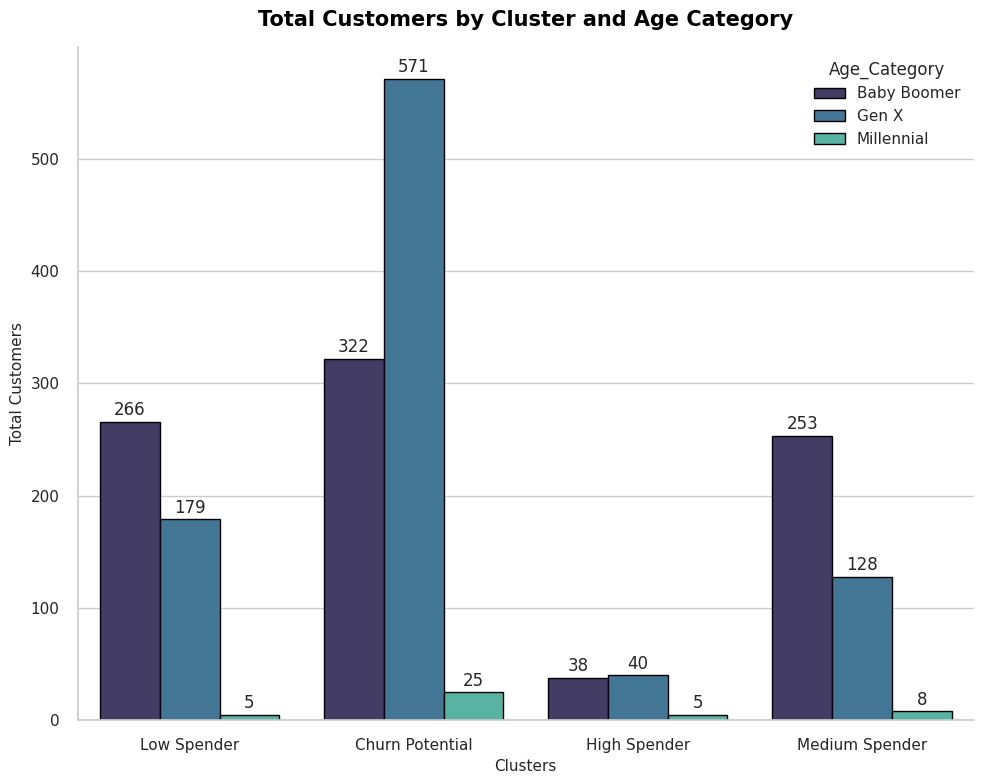

In [ ]:
df3 = df3.join(df2[['Age_Category']], how='left')

total_customers_by_cluster_age = df3.groupby(['Cluster', 'Age_Category']).size().unstack(fill_value=0)
df_tc = total_customers_by_cluster_age.reset_index().melt(id_vars='Cluster', var_name='Age_Category', value_name='Total_Customers')

# Menambahkan label kategori kluster
cluster_labels = {0: 'Low Spender', 1: 'Churn Potential', 2: 'High Spender', 3: 'Medium Spender'}
df_tc['Cluster_Label'] = df_tc['Cluster'].map(cluster_labels)

# Definisikan warna untuk setiap Age Category
age_category_colors = ['red', 'green', 'blue']

# Membuat plot
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("Total Customers by Cluster and Age Category", fontsize=15, color='black', weight='bold', pad=15)
sns.barplot(x='Cluster_Label', y='Total_Customers', hue='Age_Category', data=df_tc, edgecolor='black', palette='mako')

plt.xlabel('Clusters', fontsize=11)
plt.ylabel('Total Customers', fontsize=11)
for bar in ax.containers:
    ax.bar_label(bar, padding=2)

sns.despine()
plt.tight_layout()
plt.show()


Key Takeaways:
- Customer Low Spender di dominasi oleh customer dengan kategori umur Baby Boomer, sebanyak 266
- Customer Churn Potential di dominasi oleh customer dengan kategori umur Gen X, sebanyak 571
- High Spender di dominasi oleh kategori umur Baby Boomer sebanyak 38 dan Gen X, sebanyak 40
- Medium Spender di dominasi oleh customer dengan kategori Baby Boomer, sebanyak 253

# Marketing Retargetting

Berdasarkan Analisis Cluster, diketahui karakteristik dari setiap cluster, antara lain:

- **Cluster 0 (Low Spender):**

  Cluster ini memiliki pengeluaran yang relatif tinggi tetapi conversion rate yang rendah. Ini menunjukkan ada peluang besar untuk meningkatkan konversi dan pendapatan melalui retargeting.

- **Cluster 1 (Churn Potential):**

  Cluster ini memiliki pengeluaran dan conversion rate yang rendah. Namun, karena kategori ini adalah churn potential, retargeting mungkin lebih difokuskan untuk re-engagement atau reactivation.

- **Cluster 2 (High Spender):**

  Cluster ini sudah memiliki conversion rate yang tinggi dan pengeluaran yang besar. Retargeting mungkin tidak diperlukan karena pelanggan di cluster ini sudah sangat aktif.

- **Cluster 3 (Medium Spender):**

  Cluster ini memiliki pengeluaran yang tinggi tetapi conversion rate yang cukup rendah. Ini menunjukkan ada peluang untuk meningkatkan konversi melalui retargeting.

## Potential Impact

### Peningkatan Konversi

- Membuat asumsi peningkatan tingkat **Conversion Rate** sebesar 10% untuk melihat total pendapatan tambahan setelah tingkat Conversion Rate bertambah

In [ ]:
increase_rate = 0.10

In [ ]:
cluster_0_total_revenue_before = cluster_summary.loc[0, 'Total_Spending'] * cluster_summary.loc[0, 'Total_Customers']
cluster_3_total_revenue_before = cluster_summary.loc[3, 'Total_Spending'] * cluster_summary.loc[3, 'Total_Customers']

# Menghitung potential impact dari peningkatan konversi sebesar 10%
increase_rate = 0.5

# Menghitung potential impact untuk Cluster 0 (Low Spender)
cluster_0_current_conversion_rate = cluster_summary.loc[0, 'Conversion_Rate']
cluster_0_new_conversion_rate = cluster_0_current_conversion_rate * (1 + increase_rate)
cluster_0_total_customers = cluster_summary.loc[0, 'Total_Customers']
cluster_0_additional_conversions = (cluster_0_new_conversion_rate - cluster_0_current_conversion_rate) * cluster_0_total_customers
cluster_0_average_spending = cluster_summary.loc[0, 'Total_Spending']
cluster_0_additional_revenue = cluster_0_additional_conversions * cluster_0_average_spending

# Menghitung potential impact untuk Cluster 3 (Medium Spender)
cluster_3_current_conversion_rate = cluster_summary.loc[3, 'Conversion_Rate']
cluster_3_new_conversion_rate = cluster_3_current_conversion_rate * (1 + increase_rate)
cluster_3_total_customers = cluster_summary.loc[3, 'Total_Customers']
cluster_3_additional_conversions = (cluster_3_new_conversion_rate - cluster_3_current_conversion_rate) * cluster_3_total_customers
cluster_3_average_spending = cluster_summary.loc[3, 'Total_Spending']
cluster_3_additional_revenue = cluster_3_additional_conversions * cluster_3_average_spending

# Total revenue setelah peningkatan konversi
cluster_0_total_revenue_after = cluster_0_total_revenue_before + cluster_0_additional_revenue
cluster_3_total_revenue_after = cluster_3_total_revenue_before + cluster_3_additional_revenue

print(f'Total revenue before and after conversion rate increase for Cluster 0 (Low Spender): Rp {cluster_0_total_revenue_before:.2f} -> Rp {cluster_0_total_revenue_after:.2f}')
print(f'Total revenue before and after conversion rate increase for Cluster 3 (Medium Spender): Rp {cluster_3_total_revenue_before:.2f} -> Rp {cluster_3_total_revenue_after:.2f}')


Total revenue before and after conversion rate increase for Cluster 0 (Low Spender): Rp 208634000.00 -> Rp 209800345.01
Total revenue before and after conversion rate increase for Cluster 3 (Medium Spender): Rp 420570000.00 -> Rp 425529163.33


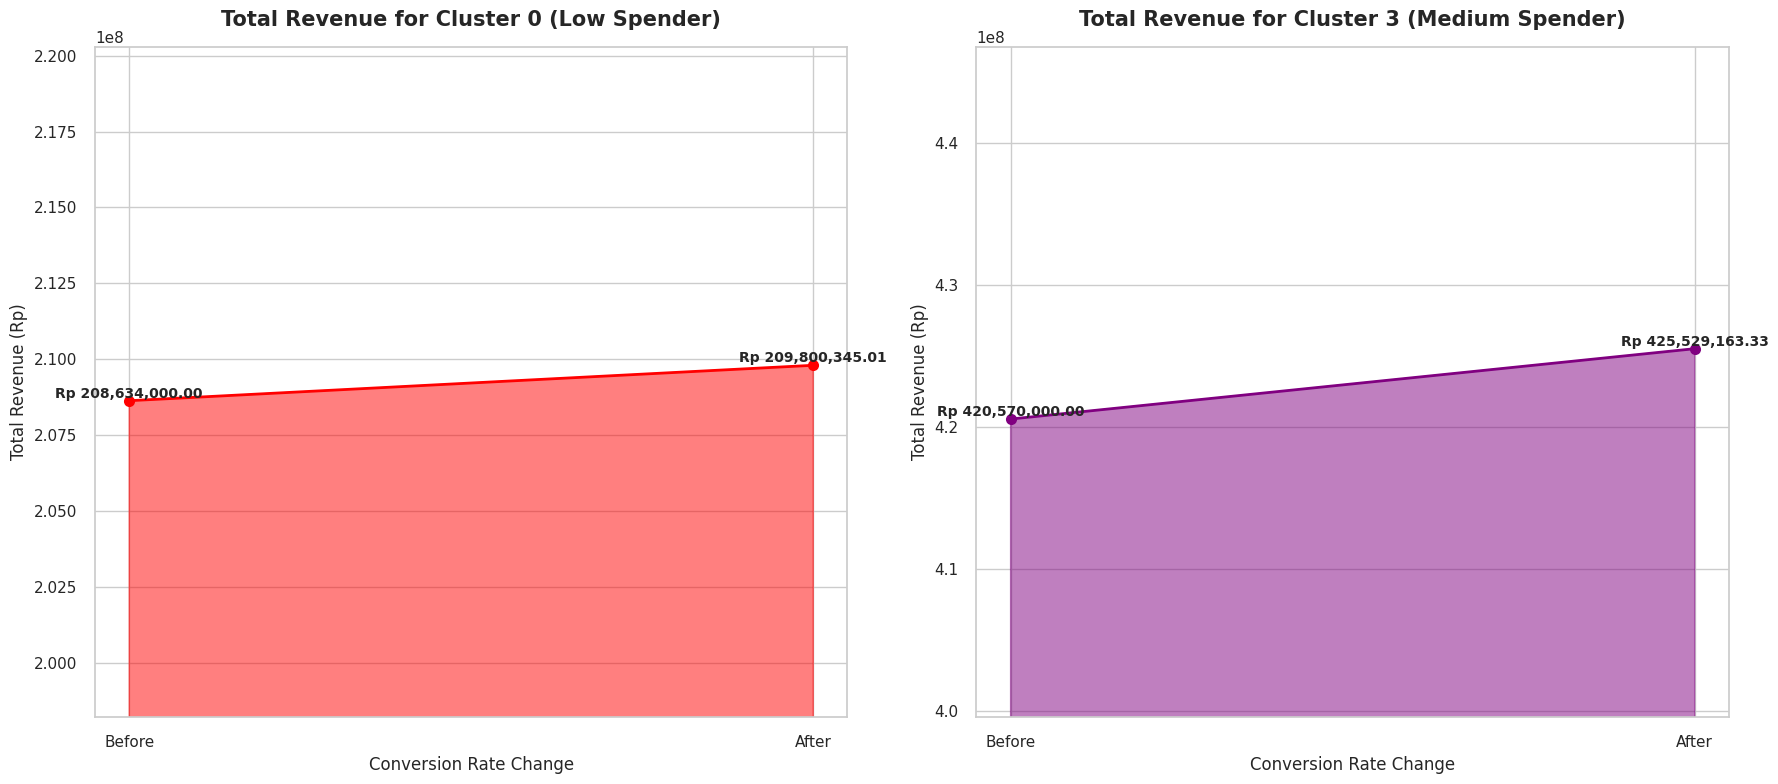

In [ ]:
x_labels = ['Before', 'After']
x = range(len(x_labels))
revenue_0 = [cluster_0_total_revenue_before, cluster_0_total_revenue_after]
revenue_3 = [cluster_3_total_revenue_before, cluster_3_total_revenue_after]

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
plt.fill_between(x, revenue_0, color='red', alpha=0.5)
plt.plot(x, revenue_0, marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
plt.title('Total Revenue for Cluster 0 (Low Spender)', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Conversion Rate Change', fontsize=12)
plt.ylabel('Total Revenue (Rp)', fontsize=12)
plt.xticks(x, x_labels)
plt.ylim(min(revenue_0) * 0.95, max(revenue_0) * 1.05)
for i, value in enumerate(revenue_0):
    plt.text(x=i, y=value, s=f'Rp {value:,.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.subplot(1, 2, 2)
plt.fill_between(x, revenue_3, color='purple', alpha=0.5)
plt.plot(x, revenue_3, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
plt.title('Total Revenue for Cluster 3 (Medium Spender)', fontsize=15, fontweight='bold', pad=15)
plt.xlabel('Conversion Rate Change', fontsize=12)
plt.ylabel('Total Revenue (Rp)', fontsize=12)
plt.xticks(x, x_labels)
plt.ylim(min(revenue_3) * 0.95, max(revenue_3) * 1.05)
for i, value in enumerate(revenue_3):
    plt.text(x=i, y=value, s=f'Rp {value:,.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Pengurangan Tingkat Churn
- Membuat asumsi pengurangan tingkat **Churn** sebesar 5% untuk melihat total pendapatan tambahan setelah tingkat churn berkurang

In [ ]:
# Menghitung total revenue sebelum pengurangan churn
cluster_0_total_revenue_before = cluster_summary.loc[0, 'Total_Spending'] * cluster_summary.loc[0, 'Total_Customers']
cluster_3_total_revenue_before = cluster_summary.loc[3, 'Total_Spending'] * cluster_summary.loc[3, 'Total_Customers']

# Asumsikan pengurangan churn rate sebesar 5%
decrease_churn_rate = 0.05

# Menghitung potential impact untuk Cluster 0 (Low Spender)
cluster_0_total_customers = cluster_summary.loc[0, 'Total_Customers']
cluster_0_new_total_customers = cluster_0_total_customers * (1 - decrease_churn_rate)
cluster_0_additional_customers = cluster_0_total_customers - cluster_0_new_total_customers
cluster_0_average_spending = cluster_summary.loc[0, 'Total_Spending']
cluster_0_additional_revenue = cluster_0_additional_customers * cluster_0_average_spending

# Menghitung potential impact untuk Cluster 3 (Medium Spender)
cluster_3_total_customers = cluster_summary.loc[3, 'Total_Customers']
cluster_3_new_total_customers = cluster_3_total_customers * (1 - decrease_churn_rate)
cluster_3_additional_customers = cluster_3_total_customers - cluster_3_new_total_customers
cluster_3_average_spending = cluster_summary.loc[3, 'Total_Spending']
cluster_3_additional_revenue = cluster_3_additional_customers * cluster_3_average_spending

# Menghitung total revenue setelah pengurangan churn
cluster_0_total_revenue_after = cluster_0_total_revenue_before + cluster_0_additional_revenue
cluster_3_total_revenue_after = cluster_3_total_revenue_before + cluster_3_additional_revenue

print(f'Total revenue before and after churn rate decrease for Cluster 0 (Low Spender): Rp {cluster_0_total_revenue_before:.2f} -> Rp {cluster_0_total_revenue_after:.2f}')
print(f'Total revenue before and after churn rate decrease for Cluster 3 (Medium Spender): Rp {cluster_3_total_revenue_before:.2f} -> Rp {cluster_3_total_revenue_after:.2f}')


Total revenue before and after churn rate decrease for Cluster 0 (Low Spender): Rp 208634000.00 -> Rp 219065700.00
Total revenue before and after churn rate decrease for Cluster 3 (Medium Spender): Rp 420570000.00 -> Rp 441598500.00


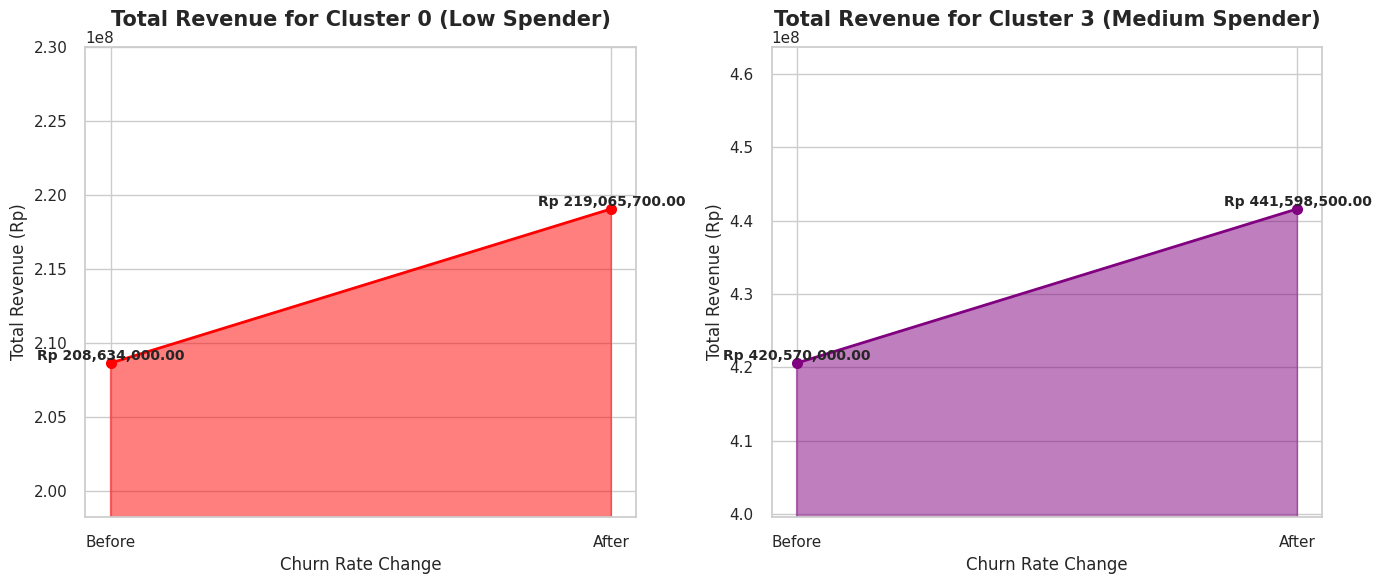

In [ ]:
clusters = ['Cluster 0 (Low Spender)', 'Cluster 3 (Medium Spender)']
x_labels = ['Before', 'After']
revenue_before = [cluster_0_total_revenue_before, cluster_3_total_revenue_before]
revenue_after = [cluster_0_total_revenue_after, cluster_3_total_revenue_after]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].fill_between(x_labels, [revenue_before[0], revenue_after[0]], color='red', alpha=0.5)
axs[0].plot(x_labels, [revenue_before[0], revenue_after[0]], marker='o', color='red', linestyle='-', linewidth=2, markersize=8)
axs[0].set_title('Total Revenue for Cluster 0 (Low Spender)', fontsize=15, fontweight='bold', pad=15)
axs[0].set_xlabel('Churn Rate Change', fontsize=12)
axs[0].set_ylabel('Total Revenue (Rp)', fontsize=12)
axs[0].set_ylim(min(revenue_before[0], revenue_after[0]) * 0.95, max(revenue_before[0], revenue_after[0]) * 1.05)
for i, value in enumerate([revenue_before[0], revenue_after[0]]):
    axs[0].text(x=x_labels[i], y=value, s=f'Rp {value:,.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

axs[1].fill_between(x_labels, [revenue_before[1], revenue_after[1]], color='purple', alpha=0.5)
axs[1].plot(x_labels, [revenue_before[1], revenue_after[1]], marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
axs[1].set_title('Total Revenue for Cluster 3 (Medium Spender)', fontsize=15, fontweight='bold', pad=15)
axs[1].set_xlabel('Churn Rate Change', fontsize=12)
axs[1].set_ylabel('Total Revenue (Rp)', fontsize=12)
axs[1].set_ylim(min(revenue_before[1], revenue_after[1]) * 0.95, max(revenue_before[1], revenue_after[1]) * 1.05)
for i, value in enumerate([revenue_before[1], revenue_after[1]]):
    axs[1].text(x=x_labels[i], y=value, s=f'Rp {value:,.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()